In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
p = 3
sigma = 0.1
beta_true = [0.3, -0.1, 0.7, 0.8, 0.5, -0.4]
#beta_true = [3, -1, 7, 8, 5, -4]

# Model Realization

In [3]:
def u(A, X, beta):
    if type(A) == int:
        if A == 1:
            return(X.dot(beta[p:]))
        else:
            return(X.dot(beta[:p]))
    else:
        return((1 - A) * X.dot(beta[:p]) + A * X.dot(beta[p:]))

In [4]:
def sigmoid(x):
    return(1/(1 + np.exp(-x)))

In [5]:
def logit(A, X, beta):
    return(2 * sigmoid(u(A, X, beta)) - 1)

In [6]:
def logit01(A, X, beta):
    return(sigmoid(u(A, X, beta)))

In [7]:
def gu(A, X, beta):
    return(np.vstack(((1 - A) * X.T, A * X.T)))

## Data generation

In [8]:
def LinearGenerator(n=1, X=None, A=None, generate_Y=False):
    if X is None:
        X = np.empty((n, p))
        X[:, 0] = 1.0
        X[:, 1:] = np.random.normal(0, 1, size = (n, (p - 1)))
    else:
        assert X.shape[1] == p
        n = X.shape[0]
    if not generate_Y:
        return(X, A)
    elif A is not None:
        # if A not 0 or 1, raise error
        Y = u(A, X, beta_true) + np.random.normal(0, sigma, n)
        return((X, A, Y))
    else:
        Y0 = u(0, X, beta_true) + np.random.normal(0, sigma, n)
        Y1 = u(1, X, beta_true) + np.random.normal(0, sigma, n)
        Y = {'0': Y0, '1': Y1}
        return((X, A, Y))

In [9]:
O = LinearGenerator(n = 10000, generate_Y = True)
X, A, Y = O

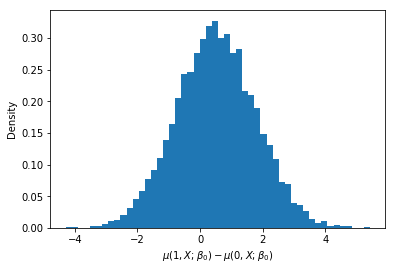

In [25]:
plt.hist(Y['1'] - Y['0'], 50, density=True)
plt.xlabel(r'$\mu(1, X; \beta_0) - \mu(0, X; \beta_0)$')
plt.ylabel('Density')
plt.savefig("linear_data.pdf")

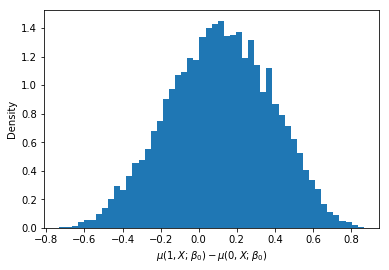

In [26]:
plt.hist(sigmoid(Y['1']) - sigmoid(Y['0']), 50, density=True)
plt.xlabel(r'$\mu(1, X; \beta_0) - \mu(0, X; \beta_0)$')
plt.ylabel('Density')
plt.savefig("logistic_data.pdf")

In [9]:
def LogisticGenerator(n=1, X=None, A=None, generate_Y=False):
    if X is None:
        X = np.empty((n, p))
        X[:, 0] = 1.0
        X[:, 1:] = np.random.normal(0, 1, size = (n, (p - 1)))
    else:
        assert X.shape[1] == p
        n = X.shape[0]
    if not generate_Y:
        return(X, A)
    elif A is not None:
        # if A not 0 or 1, raise error
        # if size of A does not match X.shape[0], raise error
        Y = (np.random.binomial(1, logit01(A, X, beta_true)) - 0.5) * 2
        return((X, A, Y))
    else:
        Y0 = (np.random.binomial(1, logit01(0, X, beta_true)) - 0.5) * 2
        Y1 = (np.random.binomial(1, logit01(1, X, beta_true)) - 0.5) * 2
        Y = {'0': Y0, '1': Y1}
        return((X, A, Y))

In [10]:
def LogisticGenerator01(n=1, X=None, A=None, generate_Y=False):
    if X is None:
        X = np.empty((n, p))
        X[:, 0] = 1.0
        X[:, 1:] = np.random.normal(0, 1, size = (n, (p - 1)))
    else:
        assert X.shape[1] == p
        n = X.shape[0]
    if not generate_Y:
        return(X, A)
    elif A is not None:
        # if A not 0 or 1, raise error
        # if size of A does not match X.shape[0], raise error
        Y = np.random.binomial(1, logit01(A, X, beta_true))
        return((X, A, Y))
    else:
        Y0 = np.random.binomial(1, logit01(0, X, beta_true))
        Y1 = np.random.binomial(1, logit01(1, X, beta_true))
        Y = {'0': Y0, '1': Y1}
        return((X, A, Y))

## Loss functions

In [11]:
def MSELoss(beta, O, gradient_only = False, return_second_moment = False):
    X, A, Y = O
    n = X.shape[0]
    e = u(A, X, beta) - Y
    if not return_second_moment:
        grad = np.dot(gu(A, X, beta), e)/n
        if gradient_only:
            return(grad)
        else:
            l = np.dot(e, e)/(2 * n)
        return((l, grad))
    else:
        gu_v = gu(A, X, beta)
        grad_v = gu_v * e
        Sigma = grad_v.dot(grad_v.T)/n
        Hessian = gu_v.dot(gu_v.T)/n
        return((Sigma, Hessian))

In [12]:
def LogisticLoss(beta, O, gradient_only = False, return_second_moment = False):
    X, A, Y = O
    n = X.shape[0]
    lo = sigmoid(-Y * u(A, X, beta))
    if not return_second_moment:
        grad = -np.dot(gu(A, X, beta), lo * Y)/n
        if gradient_only:
            return(grad)
        else:
            l = np.mean(np.log(1 + np.exp(-Y * u(A, X, beta))))
        return((l, grad))
    else:
        gu_v = gu(A, X, beta)
        grad_v = gu_v * lo * Y
        Sigma = grad_v.dot(grad_v.T)/n
        Hessian = np.dot(gu_v * lo * (1 - lo), gu_v.T)/n
        return((Sigma, Hessian))

In [13]:
def BCELoss(beta, O, gradient_only = False, return_second_moment = False):
    X, A, Y = O
    n = X.shape[0]
    mu = logit01(A, X, beta)
    if not return_second_moment:
        grad = np.dot(gu(A, X, beta), mu - Y)/n
        if gradient_only:
            return(grad)
        else:
            l = np.mean(-Y * np.log(mu) - (1 - Y) * np.log(1 - mu))
        return((l, grad))
    else:
        gu_v = gu(A, X, beta)
        grad_v = gu_v * (mu - Y)
        Sigma = grad_v.dot(grad_v.T)/n
        Hessian = np.dot(gu_v * mu * (1 - mu), gu_v.T)/n
        return((Sigma, Hessian))

## Estimation using SGD

In [14]:
class model:
    def __init__(self, mu, generator, loss, 
                 eps = None, eps_inf = 0.01, 
                 alpha = 1, gamma = 2/3):
        self.mu = mu
        self.generator = generator
        self.loss = loss
        if eps is None:
            self.eps = lambda x: eps_inf
        else:
            self.eps = eps
        self.eps_inf = eps_inf
        self.alpha = alpha
        self.gamma = gamma
        self.lr = lambda x: alpha * x**(-gamma)
        
    def Initialize(self):
        self.beta_hat = np.zeros(2 * p)
        self.beta_bar = np.zeros(2 * p)
        self.data = []
        self.pi_log = [] # start from step 0
        #self.beta_hat_log = [self.beta_hat.copy()] # start from step 1
        self.beta_bar_log = [self.beta_bar.copy()] # start from step 1
        self.loss_log = []
        self.step = 0
        # initialization for plugin variance estimation
        self.S_hat = np.zeros((2 * p, 2 * p))
        self.H_hat = np.zeros((2 * p, 2 * p))
        self.se_hat = np.zeros(2 * p)
        # initialization for value estimation
        self.val_hat = 0.
        self.val_hat_log = []
        self.cum_Y = 0.
        self.cum_Ysq = 0.
        self.vse_hat = 0.
        # initialization for DoubleWeighting method
        self.beta_hat_b = None
        self.beta_bar_b = None
        
        
    def SGD(self, T, use_IPW = True, explore = False, real_data = False):
        for t in range(self.step, self.step + T):
            match = False
            while not match:
                # observe X_t
                X, real_A = self.generator()
                if explore:
                    epsilon = 1
                    d = 0
                    self.pi_hat = 0.5
                else:
                    # update pi_hat_t-1(X_t)
                    epsilon = self.eps(t + 1)
                    d = int(self.mu(1, X, self.beta_bar) > self.mu(0, X, self.beta_bar))
                    self.pi_hat = (1 - epsilon) * d + epsilon/2 
                # sample A_t from Bernoulli pi_hat
                A = np.random.binomial(1, self.pi_hat)
                if not real_data:
                    match = True
                else:
                    match = (A == real_A)
                    if not match:
                        data.loc[data[data.match == 0].index[0], 'match'] = -1
            # observe Y_t
            O = self.generator(X = X, A = A, generate_Y = True)
            Y = O[2].squeeze()
            # update treatment consistency
            C = int(A == d)
            pi_C = 1 - epsilon/2
            # update value estimation
            self.cum_Y += C * Y/pi_C
            self.cum_Ysq += C * Y**2/pi_C
            self.val_hat = self.cum_Y/(t + 1)
            # calculate IPW
            if use_IPW:
                IPW = (A/self.pi_hat + (1 - A)/(1 - self.pi_hat))/2
            else:
                IPW = 1
            # update second moment estimation
            S, H = self.loss(self.beta_bar, O, return_second_moment = True)
            self.S_hat += S * IPW**2
            self.H_hat += H * IPW
            # update beta_hat_t
            learning_rate = self.lr(t + 1)
            l, g = self.loss(self.beta_hat, O) 
            g *= IPW
            self.beta_hat -= learning_rate * g
            # update beta_bar_t
            self.beta_bar = (self.beta_hat + t * self.beta_bar)/(t + 1)
            # log historical info, need this if using PluginParameterVariance
            # self.data.append(O)
            # self.pi_log.append(self.pi_hat)
            #self.beta_hat_log.append(self.beta_hat.copy())
            self.beta_bar_log.append(self.beta_bar.copy())
            self.val_hat_log.append(self.val_hat)
            self.loss_log.append(l)
            self.step = t + 1
        S_hat = self.S_hat/self.step
        H_hat = self.H_hat/self.step
        H_hat_inv = np.linalg.inv(H_hat)
        V_hat = np.dot(np.dot(H_hat_inv, S_hat), H_hat_inv)
        self.se_hat = np.sqrt(np.diag(V_hat)/self.step)
        self.vse_hat = np.sqrt((self.cum_Ysq/self.step * 2/(2 - epsilon) - 
                                self.val_hat**2)/self.step)
        
    def BatchMeansParameterVariance(self, K=None):
        if K is None:
            K = round(self.step**((1 - self.alpha)/2))
        K = max(K, 3)
        e = [round(pow((k + 1)/(K + 1), 1/(1 - self.alpha)) * self.step) 
             for k in range(K + 1)]
        V_hat = np.zeros((2 * p, 2 * p))
        e0 = e[0]
        b0 = self.beta_bar_log[e0 - 1]
        bK_bar = (self.beta_bar * self.step - b0 * e0)/(self.step - e0)
        for k in range(K):
            ek = e[k + 1]
            bk = self.beta_bar_log[ek - 1]
            bk_bar = (bk * ek - b0 * e0)/(ek - e0)
            m = bk_bar - bK_bar
            V_hat += (ek - e0) * np.outer(m, m)
            e0 = ek
            b0 = bk
        V_hat /= K
        return(V_hat)
    
    def PluginParameterVariance(self, use_IPW = True, return_SH = False):
        S_hat = np.zeros((2 * p, 2 * p))
        H_hat = np.zeros((2 * p, 2 * p))
        IPW = 1
        for t in range(self.step):
            O = self.data[t]
            beta = self.beta_bar_log[t]
            Sigma, Hessian = self.loss(beta, O, return_second_moment = True)
            if use_IPW:
                A = O[1]
                IPW = (A/self.pi_log[t] + (1 - A)/(1 - self.pi_log[t]))/2
            S_hat += Sigma * IPW**2
            H_hat += Hessian * IPW
        S_hat /= self.step
        H_hat /= self.step
        H_hat_inv = np.linalg.inv(H_hat)
        V_hat = np.dot(np.dot(H_hat_inv, S_hat), H_hat_inv)
        if return_SH:
            return(S_hat, H_hat)
        else:
            return(V_hat)
        
    def PluginValueVariance(self):
        beta_f = self.beta_bar
        cum_Y_t = cum_Y_f = 0.
        cum_Ysq_t = cum_Ysq_f = 0.
        for t in range(self.step):
            X, A, Y = self.data[t]
            epsilon = self.eps(t + 1)
            d_f = int(self.mu(1, X, beta_f) > self.mu(0, X, beta_f))
            d_t = int(self.mu(1, X, beta_true) > self.mu(0, X, beta_true))
            C_f = int(A == d_f)
            C_t = int(A == d_t)
            pi_C = 1 - epsilon/2
            # update value estimation
            cum_Y_f += C_f * Y/pi_C
            cum_Ysq_f += C_f * Y**2/pi_C
            cum_Y_t += C_t * Y/pi_C
            cum_Ysq_t += C_t * Y**2/pi_C
        etasq_f = cum_Ysq_f/self.step * 2/(2 - epsilon) - (cum_Y_f/self.step)**2
        etasq_t = cum_Ysq_t/self.step - (cum_Y_t/self.step)**2
        return([float(etasq_f), float(etasq_t)])
        
    def DoubleWeighting(self, T, R = 100, explore = False, real_data = False):
        if self.beta_hat_b is None:
            self.beta_hat_b = np.zeros((R, 2 * p))
        if self.beta_bar_b is None:
            self.beta_bar_b = np.zeros((R, 2 * p))
        for t in range(self.step, self.step + T):
            match = False
            while not match:
                # observe X_t
                X, real_A = self.generator()
                if explore:
                    epsilon = 1
                    d = 0
                    self.pi_hat = 0.5
                else:
                    # update pi_hat_t-1(X_t)
                    epsilon = self.eps(t)
                    d = int(self.mu(1, X, self.beta_bar) > self.mu(0, X, self.beta_bar))
                    self.pi_hat = (1 - epsilon) * d + epsilon/2 
                # sample A_t from Bernoulli pi_hat
                A = np.random.binomial(1, self.pi_hat)
                if not real_data:
                    match = True
                else:
                    match = (A == real_A)
                    if not match:
                        data.loc[data[data.match == 0].index[0], 'match'] = -1
            # observe Y_t
            O = self.generator(X = X, A = A, generate_Y = True)
            # calculate gradient
            learning_rate = self.lr(t + 1)
            W_ip = (A/self.pi_hat + (1 - A)/(1 - self.pi_hat))/2   
            l, g = self.loss(self.beta_hat, O)
            # update beta_hat_t
            self.beta_hat -= learning_rate * W_ip * g
            # update beta_bar_t
            self.beta_bar = (self.beta_hat + t * self.beta_bar)/(t + 1)
            # Resampling
            W_b = np.random.exponential(size = (R, 1))
            G = np.array([self.loss(b, O, gradient_only = True) for b in self.beta_hat_b])
            self.beta_hat_b -= learning_rate * W_ip * W_b * G
            self.beta_bar_b = (self.beta_hat_b + t * self.beta_bar_b)/(t + 1)
            # log
            self.data.append(O)
            self.pi_log.append(self.pi_hat)
            #self.beta_hat_log.append(self.beta_hat.copy())
            self.beta_bar_log.append(self.beta_bar.copy())
            self.loss_log.append(l)
            self.step = t + 1
            
    def ResamplingParameterVariance(self):
        return(np.cov(self.beta_bar_b, rowvar = False))

# Simulation Study -- Linear Model Setting
 

## Evaluation of the truth
Pure exploration for the first 50 step, then $\varepsilon_t = \varepsilon_\infty = 0.05$. Learning rate is $0.5t^{-0.667}$.

In [15]:
def eps(t):
    if t <= 50:
        return(1)
    else:
        return(0.1)
        #return(min(1, 0.1 * np.log(t)/np.sqrt(t)))
        
LinearModel = model(mu = u, generator = LinearGenerator, loss = MSELoss,
                    eps = eps, eps_inf = 0.1, alpha = 0.5, gamma = 0.501)

In [15]:
N = 1000000
X, _ = LinearGenerator(N)
A = np.random.binomial(1, 0.5, N)
O = LinearGenerator(N, X, A, True)
_, H = MSELoss(beta_true, O, return_second_moment=True)
epsilon = 0.1
d = np.array(u(1, X, beta_true) > u(0, X, beta_true), dtype = float)
pi = (1 - epsilon) * d + epsilon/2
from scipy.linalg import block_diag
S = block_diag(np.dot(X.T/(1-pi), X), np.dot(X.T/pi, X))/(4 * N) * sigma**2
H_inv = np.linalg.inv(H)
V = np.dot(np.dot(H_inv, S), H_inv)
val_true = np.mean(u(d, X, beta_true))
VV = (np.mean(u(d, X, beta_true)**2) + sigma**2) * 2/(2 - epsilon) - val_true**2

In [21]:
from scipy.linalg import block_diag
def stable(epsilon):
    N = 1000000
    X, _ = LinearGenerator(N)
    A = np.random.binomial(1, 0.5, N)
    O = LinearGenerator(N, X, A, True)
    _, H = MSELoss(beta_true, O, return_second_moment=True)
    d = np.array(u(1, X, beta_true) > u(0, X, beta_true), dtype = float)
    pi = (1 - epsilon) * d + epsilon/2
    S = block_diag(np.dot(X.T/(1-pi), X), np.dot(X.T/pi, X))/(4 * N) * sigma**2
    H_inv = np.linalg.inv(H)
    V = np.dot(np.dot(H_inv, S), H_inv)
    val_true = np.mean(u(d, X, beta_true))
    VV = (np.mean(u(d, X, beta_true)**2) + sigma**2) * 2/(2 - epsilon) - val_true**2
    print(np.round(np.append(np.diag(V), VV), 4))

In [23]:
for epsilon in [0.1, 0.01, 0.001, 0.0001]:
    stable(epsilon)

[0.135  0.1294 0.1135 0.0757 0.0817 0.097  0.2968]
[1.3124 1.2482 1.0907 0.6956 0.7639 0.9191 0.2296]
[13.1094 12.3522 10.8217  6.9315  7.5796  9.2619  0.2231]
[130.7216 123.5891 108.3411  69.2022  76.1863  91.5224   0.2229]


## Parameter and its variance estimation
### Plugin estimator is consistent

In [23]:
# Plugin Method
print('True beta    :', np.round(beta_true, 3))
print('TSE * sqrt(t):', np.round(np.sqrt(np.diag(V)), 3))
LinearModel.Initialize()
for T in [1000, 9000, 90000, 900000, 1000000, 1000000]:
    LinearModel.SGD(T)
    print('Step {:8}:'.format(LinearModel.step))
    print('beta estimate:', np.round(LinearModel.beta_bar, 3))
    print('PSE * sqrt(t):', np.round(LinearModel.se_hat * np.sqrt(LinearModel.step), 3))
    print('H estimate   :', np.round(np.diag(LinearModel.H_hat/LinearModel.step), 3))
    print('S estimate   :', np.round(np.diag(LinearModel.S_hat/LinearModel.step), 3))

True beta    : [ 0.3 -0.1  0.7  0.8  0.5 -0.4]
TSE * sqrt(t): [1.146 1.116 1.042 0.835 0.874 0.963]
Step     1000:
beta estimate: [ 0.315 -0.077  0.677  0.794  0.506 -0.389]
PSE * sqrt(t): [0.598 1.088 0.37  0.437 0.317 0.498]
H estimate   : [0.464 0.464 0.562 0.575 0.692 0.552]
S estimate   : [0.097 0.27  0.052 0.068 0.032 0.072]
Step    10000:
beta estimate: [ 0.302 -0.102  0.704  0.794  0.514 -0.398]
PSE * sqrt(t): [0.888 1.074 0.705 0.502 0.483 0.599]
H estimate   : [0.492 0.37  0.507 0.488 0.447 0.515]
S estimate   : [0.177 0.155 0.126 0.058 0.043 0.096]
Step   100000:
beta estimate: [ 0.3   -0.104  0.701  0.802  0.497 -0.399]
PSE * sqrt(t): [1.176 1.124 1.016 0.854 0.787 0.938]
H estimate   : [0.478 0.473 0.453 0.502 0.498 0.543]
S estimate   : [0.294 0.279 0.197 0.19  0.149 0.271]
Step  1000000:
beta estimate: [ 0.299 -0.101  0.7    0.801  0.499 -0.399]
PSE * sqrt(t): [1.163 1.121 1.073 0.829 0.845 0.952]
H estimate   : [0.496 0.49  0.491 0.506 0.503 0.503]
S estimate   : [0.333

In [19]:
print('H:')
print(np.round(H, 3))
print('H_hat:')
print(np.round(LinearModel.H_hat/LinearModel.step, 3))
print('S:')
print(np.round(S, 3))
print('S_hat:')
print(np.round(LinearModel.S_hat/LinearModel.step, 3))

H:
[[ 0.5   -0.    -0.     0.     0.     0.   ]
 [-0.     0.5   -0.     0.     0.     0.   ]
 [-0.    -0.     0.5    0.     0.     0.   ]
 [ 0.     0.     0.     0.5   -0.    -0.   ]
 [ 0.     0.     0.    -0.     0.5    0.   ]
 [ 0.     0.     0.    -0.     0.     0.498]]
H_hat:
[[ 0.499 -0.004 -0.     0.     0.     0.   ]
 [-0.004  0.504  0.005  0.     0.     0.   ]
 [-0.     0.005  0.501  0.     0.     0.   ]
 [ 0.     0.     0.     0.498  0.    -0.002]
 [ 0.     0.     0.     0.     0.499  0.001]
 [ 0.     0.     0.    -0.002  0.001  0.497]]
S:
[[ 0.329  0.087 -0.161  0.     0.     0.   ]
 [ 0.087  0.312  0.031  0.     0.     0.   ]
 [-0.161  0.031  0.272  0.     0.     0.   ]
 [ 0.     0.     0.     0.174 -0.088  0.161]
 [ 0.     0.     0.    -0.088  0.191 -0.031]
 [ 0.     0.     0.     0.161 -0.031  0.23 ]]
S_hat:
[[ 0.225  0.057 -0.111  0.     0.     0.   ]
 [ 0.057  0.221  0.026  0.     0.     0.   ]
 [-0.111  0.026  0.192  0.     0.     0.   ]
 [ 0.     0.     0.     0.11  -0

### Tuning of learning rate

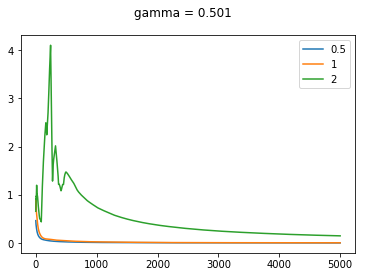

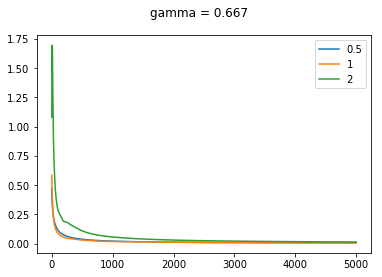

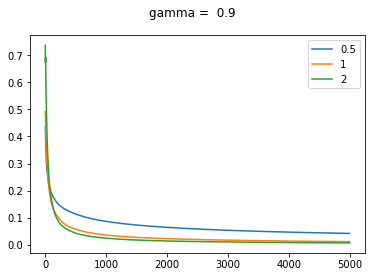

In [22]:
T = 5000
M = 10
for gamma in [0.501, 2/3, 0.9]:
    fig = plt.figure()
    fig.suptitle("gamma = {:4}".format(round(gamma, 3)))
    for alpha in [0.5, 1, 2]:
        LinearModel = model(mu = logit, generator = LinearGenerator, loss = MSELoss,
                              eps = eps, eps_inf = 0.1, alpha = alpha, gamma = gamma)
        MAE = np.zeros(T)
        for _ in range(M):
            LinearModel.Initialize()
            LinearModel.SGD(T)
            MAE += [np.mean(np.abs(beta-beta_true)) for beta in LinearModel.beta_bar_log[1:]]
        MAE /= M
        plt.plot(MAE, label = str(alpha))
    plt.legend()
    plt.show()

In [142]:
print(' ' * 28 + 'b01  b02  b03  b11  b12  b13')
for T in [10000]: #lr0.1/0.501
    np.random.seed(1)
    beta_bar, mcsd, plugin_se, cp = MCPlugin(LinearModel, T = T, M = 200)
    print('ASE/MCSD at step {:7}:'.format(T), np.round(plugin_se/mcsd, 2))
    print('Coverage at step {:7}:'.format(T), np.round(cp, 2))

                            b01  b02  b03  b11  b12  b13
ASE/MCSD at step   10000: [0.8  0.81 0.8  0.83 0.79 0.75]
Coverage at step   10000: [0.83 0.88 0.48 0.08 0.42 0.68]


In [170]:
print(' ' * 28 + 'b01  b02  b03  b11  b12  b13')
for T in [1000]: #lr0.2/0.501
    np.random.seed(1)
    beta_bar, mcsd, plugin_se, cp = MCPlugin(LinearModel, T = T, M = 200)
    print('ASE/MCSD at step {:7}:'.format(T), np.round(plugin_se/mcsd, 2))
    print('Coverage at step {:7}:'.format(T), np.round(cp, 2))

                            b01  b02  b03  b11  b12  b13
ASE/MCSD at step    1000: [0.86 0.73 0.75 0.78 0.67 0.61]
Coverage at step    1000: [0.92 0.88 0.7  0.54 0.58 0.72]


In [134]:
print(' ' * 28 + 'b01  b02  b03  b11  b12  b13')
for T in [1000]: #lr0.3/0.501
    np.random.seed(1)
    beta_bar, mcsd, plugin_se, cp = MCPlugin(LinearModel, T = T, M = 200)
    print('ASE/MCSD at step {:7}:'.format(T), np.round(plugin_se/mcsd, 2))
    print('Coverage at step {:7}:'.format(T), np.round(cp, 2))

                            b01  b02  b03  b11  b12  b13
ASE/MCSD at step    1000: [0.64 0.58 0.59 0.81 0.63 0.66]
Coverage at step    1000: [0.92 0.84 0.78 0.82 0.72 0.8 ]


In [131]:
print(' ' * 28 + 'b01  b02  b03  b11  b12  b13')
for T in [1000]: #lr0.5/0.501
    np.random.seed(1)
    beta_bar, mcsd, plugin_se, cp = MCPlugin(LinearModel, T = T, M = 200)
    print('ASE/MCSD at step {:7}:'.format(T), np.round(plugin_se/mcsd, 2))
    print('Coverage at step {:7}:'.format(T), np.round(cp, 2))

                            b01  b02  b03  b11  b12  b13
ASE/MCSD at step    1000: [0.41 0.39 0.33 0.71 0.5  0.58]
Coverage at step    1000: [0.84 0.82 0.77 0.88 0.76 0.82]


In [128]:
print(' ' * 28 + 'b01  b02  b03  b11  b12  b13')
for T in [1000]: #lr0.5
    np.random.seed(1)
    beta_bar, mcsd, plugin_se, cp = MCPlugin(LinearModel, T = T, M = 200)
    print('ASE/MCSD at step {:7}:'.format(T), np.round(plugin_se/mcsd, 2))
    print('Coverage at step {:7}:'.format(T), np.round(cp, 2))

                            b01  b02  b03  b11  b12  b13
ASE/MCSD at step    1000: [0.64 0.57 0.57 0.68 0.52 0.56]
Coverage at step    1000: [0.91 0.84 0.8  0.8  0.67 0.76]


In [122]:
print(' ' * 28 + 'b01  b02  b03  b11  b12  b13')
for T in [1000]: #lr0.8
    np.random.seed(1)
    beta_bar, mcsd, plugin_se, cp = MCPlugin(LinearModel, T = T, M = 200)
    print('ASE/MCSD at step {:7}:'.format(T), np.round(plugin_se/mcsd, 2))
    print('Coverage at step {:7}:'.format(T), np.round(cp, 2))

                            b01  b02  b03  b11  b12  b13
ASE/MCSD at step    1000: [0.44 0.5  0.43 0.59 0.5  0.55]
Coverage at step    1000: [0.86 0.86 0.82 0.88 0.78 0.84]


In [125]:
print(' ' * 28 + 'b01  b02  b03  b11  b12  b13')
for T in [1000]: #lr1.0
    np.random.seed(1)
    beta_bar, mcsd, plugin_se, cp = MCPlugin(LinearModel, T = T, M = 200)
    print('ASE/MCSD at step {:7}:'.format(T), np.round(plugin_se/mcsd, 2))
    print('Coverage at step {:7}:'.format(T), np.round(cp, 2))

                            b01  b02  b03  b11  b12  b13
ASE/MCSD at step    1000: [0.4  0.47 0.42 0.56 0.37 0.42]
Coverage at step    1000: [0.84 0.82 0.8  0.88 0.8  0.86]


In [115]:
print(' ' * 28 + 'b01  b02  b03  b11  b12  b13')
for T in [1000]: #lr1.2
    np.random.seed(1)
    beta_bar, mcsd, plugin_se, cp = MCPlugin(LinearModel, T = T, M = 200)
    print('ASE/MCSD at step {:7}:'.format(T), np.round(plugin_se/mcsd, 2))
    print('Coverage at step {:7}:'.format(T), np.round(cp, 2))

                            b01  b02  b03  b11  b12  b13
ASE/MCSD at step    1000: [0.42 0.37 0.33 0.51 0.31 0.31]
Coverage at step    1000: [0.84 0.81 0.76 0.86 0.82 0.84]


In [119]:
print(' ' * 28 + 'b01  b02  b03  b11  b12  b13')
for T in [1000]: #lr1.5
    np.random.seed(1)
    beta_bar, mcsd, plugin_se, cp = MCPlugin(LinearModel, T = T, M = 200)
    print('ASE/MCSD at step {:7}:'.format(T), np.round(plugin_se/mcsd, 2))
    print('Coverage at step {:7}:'.format(T), np.round(cp, 2))

                            b01  b02  b03  b11  b12  b13
ASE/MCSD at step    1000: [0.27 0.25 0.22 0.41 0.3  0.26]
Coverage at step    1000: [0.78 0.77 0.72 0.83 0.75 0.8 ]


### Comparison of estimation methods
Plugin, Resampling and BatchMean estimators

In [237]:
LinearModel = model(mu = u, generator = LinearGenerator, loss = MSELoss,
                    eps = eps, eps_inf = 0.05, alpha = 0.1, gamma = 0.501)
# Plugin Method vs. Resampling Method
LinearModel.Initialize()
print('TSE * sqrt(t):', np.round(np.sqrt(np.diag(V)), 3))
for T in [1000, 9000, 90000, 900000]:
    LinearModel.DoubleWeighting(T = T, R = 200)
    print('Step {:8}:'.format(LinearModel.step))
    print('PSE * sqrt(t):', np.round(np.sqrt(np.diag(LinearModel.PluginParameterVariance())), 3))
    print('RSE * sqrt(t):', np.round(np.sqrt(np.diag(LinearModel.ResamplingParameterVariance() * LinearModel.step)), 3))

TSE * sqrt(t): [0.515 0.502 0.471 0.381 0.397 0.434]
Step     1000:
PSE * sqrt(t): [1.465 1.528 1.408 0.783 1.084 0.97 ]
RSE * sqrt(t): [1.595 1.486 1.497 1.16  1.089 1.279]
Step    10000:
PSE * sqrt(t): [0.549 0.483 0.615 0.434 0.572 0.531]
RSE * sqrt(t): [0.813 0.904 0.753 0.623 0.656 0.743]
Step   100000:
PSE * sqrt(t): [0.529 0.496 0.517 0.392 0.443 0.457]
RSE * sqrt(t): [0.616 0.546 0.587 0.406 0.464 0.449]
Step  1000000:
PSE * sqrt(t): [0.521 0.507 0.486 0.38  0.399 0.436]
RSE * sqrt(t): [0.518 0.509 0.512 0.396 0.391 0.433]


In [ ]:
for T in [4000000]:
    LinearModel.DoubleWeighting(T = T, R = 200)
    print('Step {:8}:'.format(LinearModel.step))
    print('PSE * sqrt(t):', np.round(np.sqrt(np.diag(LinearModel.PluginParameterVariance())), 3))
    print('RSE * sqrt(t):', np.round(np.sqrt(np.diag(LinearModel.ResamplingParameterVariance() * T)), 3))

In [190]:
def MC(model, T, R, M):
    beta_bar = np.zeros((M, 2 * p))
    P_se_log = np.zeros((M, 2 * p))
    R_se_log = np.zeros((M, 2 * p))
    BM_se_log = np.zeros((M, 2 * p))
    P_cp = np.zeros(2 * p)
    R_cp = np.zeros(2 * p)
    BM_cp = np.zeros(2 * p)
    for i in range(M):
        model.Initialize()
        model.DoubleWeighting(T = T, R = R)
        beta_bar[i, :] = model.beta_bar
        P_se_i = np.sqrt(np.diag(model.PluginParameterVariance())/T)
        P_se_log[i, :] = P_se_i
        R_se_i = np.sqrt(np.diag(model.ResamplingParameterVariance()))
        R_se_log[i, :] = R_se_i
        BM_se_i = np.sqrt(np.diag(model.BatchMeansParameterVariance())/T)
        BM_se_log[i, :] = BM_se_i
        cover_P = np.abs(beta_true - model.beta_bar) <= 1.96 * P_se_i
        cover_R = np.abs(beta_true - model.beta_bar) <= 1.96 * R_se_i
        cover_BM = np.abs(beta_true - model.beta_bar) <= 1.96 * BM_se_i
        P_cp += np.array(cover_P, dtype=float)
        R_cp += np.array(cover_R, dtype=float)
        BM_cp += np.array(cover_BM, dtype=float)
    mcsd = np.std(beta_bar, axis = 0)
    P_se = np.mean(P_se_log, axis = 0)
    R_se = np.mean(R_se_log, axis = 0)
    BM_se = np.mean(BM_se_log, axis = 0)
    P_cp /= M
    R_cp /= M
    BM_cp /= M
    return(beta_bar, mcsd, P_se, P_cp, R_se, R_cp, BM_se, BM_cp)

In [194]:
LinearModel = model(mu = u, generator = LinearGenerator, loss = MSELoss,
                    eps = eps, eps_inf = 0.05, alpha = 0.5, gamma = 2/3)
print(' ' * 29 + 'b01  b02  b03  b11  b12  b13')
for T in [100]: #lr = 0.5*t^(-0.667)
    np.random.seed(1)
    beta_bar, mcsd, P_se, P_cp, R_se, R_cp, BM_se, BM_cp = MC(LinearModel, T = T, R = 200, M = 200)
    print('PSE/MCSD at step {:8}:'.format(T), np.round(P_se/mcsd, 2))
    print('PluginCP at step {:8}:'.format(T), np.round(P_cp, 2))
    print('RSE/MCSD at step {:8}:'.format(T), np.round(R_se/mcsd, 2))
    print('ResampCP at step {:8}:'.format(T), np.round(R_cp, 2))
    print('BMSE/MCSD at step {:7}:'.format(T), np.round(BM_se/mcsd, 2))
    print('BtchMnCP at step {:8}:'.format(T), np.round(BM_cp, 2))

                             b01  b02  b03  b11  b12  b13
PSE/MCSD at step      100: [0.7  0.65 0.4  0.7  0.62 0.61]
PluginCP at step      100: [0.9  0.86 0.78 0.61 0.76 0.77]
RSE/MCSD at step      100: [1.6  1.78 1.12 1.63 1.43 1.43]
ResampCP at step      100: [0.98 1.   0.82 0.86 0.84 0.88]
BMSE/MCSD at step     100: [0.24 0.23 0.16 0.31 0.23 0.22]
BtchMnCP at step      100: [0.34 0.28 0.22 0.16 0.2  0.24]


In [ ]:
# A parallel version of the above cell 
# Do not run on jupyter notebook

from multiprocessing import Pool
from functools import partial

def MC1(model, T, R):
    np.random.seed()
    model.Initialize()
    model.DoubleWeighting(T = T, R = R)
    P_se = np.sqrt(np.diag(model.PluginParameterVariance())/T)
    R_se = np.sqrt(np.diag(model.ResamplingParameterVariance()))
    BM_se = np.sqrt(np.diag(model.BatchMeansParameterVariance())/T)
    P_cp = np.array(np.abs(beta_true - model.beta_bar) <= 1.96 * P_se, dtype=float)
    R_cp = np.array(np.abs(beta_true - model.beta_bar) <= 1.96 * R_se, dtype=float)
    BM_cp = np.array(np.abs(beta_true - model.beta_bar) <= 1.96 * BM_se, dtype=float)
    return(model.beta_bar, P_se, P_cp, R_se, R_cp, BM_se, BM_cp)

def ParallelMC(model, T, R, M, num_procs):
    pool = Pool(num_procs)
    _MC1_ = partial(MC1, model = model, T = T, R = R)
    experiments = [pool.apply_async(_MC1_) for _ in range(M)]
    beta_bar = [e.get()[0] for e in experiments]
    P_se_log = [e.get()[1] for e in experiments]
    P_cp_log = [e.get()[2] for e in experiments]
    R_se_log = [e.get()[3] for e in experiments]
    R_cp_log = [e.get()[4] for e in experiments]
    BM_se_log = [e.get()[5] for e in experiments]
    BM_cp_log = [e.get()[6] for e in experiments]
    mcsd = np.std(beta_bar, axis = 0)
    P_se = np.mean(P_se_log, axis = 0)
    P_cp = np.mean(P_cp_log, axis = 0)
    R_se = np.mean(R_se_log, axis = 0)
    R_cp = np.mean(R_cp_log, axis = 0)
    BM_se = np.mean(BM_se_log, axis = 0)
    BM_cp = np.mean(BM_cp_log, axis = 0)
    return(beta_bar, mcsd, P_se, P_cp, R_se, R_cp, BM_se, BM_cp)

if __name__ == '__main__':
    LinearModel = model(mu = u, generator = LinearGenerator, loss = MSELoss,
                        eps = eps, eps_inf = 0.05, alpha = 0.5, gamma = 2/3) #lr = 0.5*t^(-0.667)
    print(' ' * 29 + 'b01  b02  b03  b11  b12  b13')
    for T in [1000, 10000, 100000]:
        _, mcsd, P_se, P_cp, R_se, R_cp, BM_se, BM_cp = ParallelMC(LinearModel, T = T, R = 200, M = 200, num_procs = 16)
        print('PSE/MCSD at step {:8}:'.format(T), np.round(P_se/mcsd, 2))
        print('PluginCP at step {:8}:'.format(T), np.round(P_cp, 2))
        print('RSE/MCSD at step {:8}:'.format(T), np.round(R_se/mcsd, 2))
        print('ResampCP at step {:8}:'.format(T), np.round(R_cp, 2))
        print('BMSE/MCSD at step {:7}:'.format(T), np.round(BM_se/mcsd, 2))
        print('BtchMnCP at step {:8}:'.format(T), np.round(BM_cp, 2))
        
# Output:
#                              b01  b02  b03  b11  b12  b13
# PSE/MCSD at step     1000: [0.48 0.57 0.54 0.71 0.56 0.61]
# PluginCP at step     1000: [0.89 0.84 0.8  0.77 0.72 0.8 ]
# RSE/MCSD at step     1000: [1.93 2.89 2.35 2.73 2.5  2.46]
# ResampCP at step     1000: [1.   1.   0.95 1.   0.94 0.98]
# BMSE/MCSD at step    1000: [0.27 0.36 0.36 0.47 0.4  0.38]
# BtchMnCP at step     1000: [0.57 0.52 0.55 0.6  0.55 0.54]
# PSE/MCSD at step    10000: [0.77 0.64 0.85 0.79 0.76 0.73]
# PluginCP at step    10000: [0.9  0.86 0.91 0.89 0.85 0.92]
# RSE/MCSD at step    10000: [2.72 2.72 3.58 2.2  1.96 2.27]
# ResampCP at step    10000: [1.   1.   1.   0.98 0.98 1.  ]
# BMSE/MCSD at step   10000: [0.66 0.59 0.78 0.66 0.66 0.63]
# BtchMnCP at step    10000: [0.81 0.76 0.84 0.8  0.78 0.79]
# PSE/MCSD at step   100000: [0.92 1.01 0.95 0.89 0.96 0.91]
# PluginCP at step   100000: [0.94 0.96 0.94 0.91 0.94 0.92]
# RSE/MCSD at step   100000: [1.48 1.84 1.68 1.55 1.96 2.21]
# ResampCP at step   100000: [0.97 0.99 0.98 0.96 0.98 0.96]
# BMSE/MCSD at step  100000: [0.69 0.77 0.76 0.68 0.76 0.75]
# BtchMnCP at step   100000: [0.8  0.84 0.85 0.83 0.84 0.87]

if __name__ == '__main__':
    LinearModel = model(mu = u, generator = LinearGenerator, loss = MSELoss,
                        eps = eps, eps_inf = 0.05, alpha = 0.2, gamma = 0.501) #lr = 0.2*t^(-0.501)
    print(' ' * 29 + 'b01  b02  b03  b11  b12  b13')
    for T in [1000, 10000, 100000]:
        _, mcsd, P_se, P_cp, R_se, R_cp, BM_se, BM_cp = ParallelMC(LinearModel, T = T, R = 200, M = 200, num_procs = 16)
        print('PSE/MCSD at step {:8}:'.format(T), np.round(P_se/mcsd, 2))
        print('PluginCP at step {:8}:'.format(T), np.round(P_cp, 2))
        print('RSE/MCSD at step {:8}:'.format(T), np.round(R_se/mcsd, 2))
        print('ResampCP at step {:8}:'.format(T), np.round(R_cp, 2))
        print('BMSE/MCSD at step {:7}:'.format(T), np.round(BM_se/mcsd, 2))
        print('BtchMnCP at step {:8}:'.format(T), np.round(BM_cp, 2))
        
# Output:
# PSE/MCSD at step     1000: [0.8  0.66 0.61 0.82 0.72 0.7 ]
# PluginCP at step     1000: [0.88 0.86 0.72 0.51 0.64 0.77]
# RSE/MCSD at step     1000: [1.95 1.96 1.63 2.09 2.03 1.89]
# ResampCP at step     1000: [1.   1.   0.92 0.86 0.9  0.93]
# BMSE/MCSD at step    1000: [0.27 0.23 0.29 0.5  0.36 0.31]
# BtchMnCP at step     1000: [0.38 0.34 0.27 0.2  0.27 0.34]
# PSE/MCSD at step    10000: [0.78 0.85 0.71 0.95 0.81 0.93]
# PluginCP at step    10000: [0.92 0.9  0.86 0.81 0.82 0.92]
# RSE/MCSD at step    10000: [1.72 1.96 1.71 1.6  1.42 1.69]
# ResampCP at step    10000: [0.97 0.98 0.96 0.95 0.94 0.98]
# BMSE/MCSD at step   10000: [0.39 0.44 0.4  0.54 0.44 0.47]
# BtchMnCP at step    10000: [0.55 0.64 0.6  0.49 0.54 0.56]
# PSE/MCSD at step   100000: [0.99 0.98 1.09 0.95 0.9  0.89]
# PluginCP at step   100000: [0.96 0.96 0.96 0.9  0.92 0.92]
# RSE/MCSD at step   100000: [1.29 1.36 1.52 1.15 1.18 1.14]
# ResampCP at step   100000: [0.98 1.   0.99 0.94 0.96 0.96]
# BMSE/MCSD at step  100000: [0.49 0.49 0.54 0.48 0.45 0.45]
# BtchMnCP at step   100000: [0.64 0.63 0.7  0.61 0.6  0.62]

In [2]:
ax = np.array([[0.48, 0.57, 0.54, 0.71, 0.56, 0.61],
               [0.77, 0.64, 0.85, 0.79, 0.76, 0.73],
               [0.92, 1.01, 0.95, 0.89, 0.96, 0.91]])
ay = np.array([[0.89, 0.84, 0.8 , 0.77, 0.72, 0.8 ],
               [0.9 , 0.86, 0.91, 0.89, 0.85, 0.92],
               [0.94, 0.96, 0.94, 0.91, 0.94, 0.92]])
bx = np.array([[1.93, 2.89, 2.35, 2.73, 2.5 , 2.46],
               [2.72, 2.72, 3.58, 2.2 , 1.96, 2.27],
               [1.48, 1.84, 1.68, 1.55, 1.96, 2.21]])
by = np.array([[1.  , 1.  , 0.95, 1.  , 0.94, 0.98],
               [1.  , 1.  , 1.  , 0.98, 0.98, 1.  ],
               [0.97, 0.99, 0.98, 0.96, 0.98, 0.96]])
cx = np.array([[0.27, 0.36, 0.36, 0.47, 0.4 , 0.38],
               [0.66, 0.59, 0.78, 0.66, 0.66, 0.63],
               [0.69, 0.77, 0.76, 0.68, 0.76, 0.75]])
cy = np.array([[0.57, 0.52, 0.55, 0.6 , 0.55, 0.54],
               [0.81, 0.76, 0.84, 0.8 , 0.78, 0.79],
               [0.8 , 0.84, 0.85, 0.83, 0.84, 0.87]])

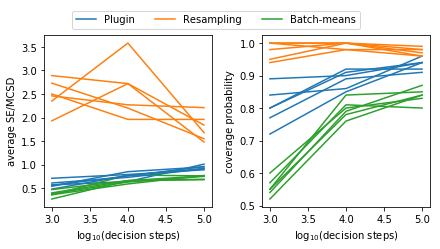

In [59]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

f, (ax1,ax2) = plt.subplots(1, 2, figsize=(6,3), constrained_layout=True)

T = [1000, 10000, 100000]
x = [ax, bx, cx]
y = [ay, by, cy]
method = ['Plugin', 'Resampling', 'Batch-means']
for j in range(6):
    for k in range(3):
        if j == 0:
            ax1.plot(np.log10(T), x[k][:, j], color = colors[k], label = method[k])
        else:
            ax1.plot(np.log10(T), x[k][:, j], color = colors[k])
        ax2.plot(np.log10(T), y[k][:, j], color = colors[k])
ax1.set_xlabel("$\log_{10}$(decision steps)")
ax1.set_ylabel("average SE/MCSD")
ax2.set_xlabel("$\log_{10}$(decision steps)")
ax2.set_ylabel("coverage probability")
f.legend(bbox_to_anchor=(0.5,1.02), loc="lower center", borderaxespad=0, ncol=3)
plt.savefig("linear_variance_estimation.pdf", bbox_inches='tight')

In [233]:
# Mini-Batch Method
print('TSE * sqrt(t):', np.round(np.sqrt(np.diag(V)), 3))
LinearModel.Initialize()
for T in [1000, 9000, 90000, 900000]:
    LinearModel.MBGD(T = T, B = 10)
    print('Step {:7}:'.format(LinearModel.step))
    print('beta estimate:', np.round(LinearModel.beta_bar, 3))
    print('se estimate  :', np.round(LinearModel.se_hat * np.sqrt(LinearModel.step), 3))
    print('H estimate   :', np.round(np.diag(LinearModel.H_hat/LinearModel.step), 3))
    print('S estimate   :', np.round(np.diag(LinearModel.S_hat/LinearModel.step), 3))

TSE * sqrt(t): [0.515 0.502 0.471 0.381 0.397 0.434]
Step    1000:
beta estimate: [ 0.141 -0.04   0.219  0.217  0.087 -0.14 ]
se estimate  : [1.468 1.023 2.185 2.384 1.824 2.298]
H estimate   : [0.434 0.561 0.325 0.439 0.34  0.331]
S estimate   : [0.256 0.325 0.379 0.877 0.376 0.422]
Step   10000:
beta estimate: [ 0.223 -0.052  0.416  0.48   0.288 -0.246]
se estimate  : [1.518 1.812 2.5   1.314 1.92  1.379]
H estimate   : [0.5   0.51  0.494 0.519 0.54  0.547]
S estimate   : [0.566 0.9   1.555 0.475 1.093 0.608]
Step  100000:
beta estimate: [ 0.273 -0.084  0.616  0.703  0.433 -0.352]
se estimate  : [0.909 0.965 1.362 0.682 0.893 0.8  ]
H estimate   : [0.488 0.487 0.497 0.494 0.493 0.495]
S estimate   : [0.192 0.222 0.452 0.113 0.194 0.157]
Step 1000000:
beta estimate: [ 0.295 -0.099  0.688  0.785  0.49  -0.393]
se estimate  : [0.579 0.579 0.649 0.431 0.488 0.498]
H estimate   : [0.496 0.492 0.496 0.501 0.502 0.501]
S estimate   : [0.082 0.081 0.103 0.047 0.06  0.062]


## Value and its variance estimation

In [21]:
def eps(t):
    if t <= 50:
        return(1)
    else:
        return(max(t**(-0.3), 0.1))
    
LinearModel = model(mu = u, generator = LinearGenerator, loss = MSELoss,
                    eps = eps, eps_inf = 0.1, alpha = 0.5, gamma = 0.501)

In [34]:
print(' ' * 14 + 'Value VSE*rt')
print('True       : {:6} {:6}'.format(round(val_true, 4), round(np.sqrt(VV), 4)))
LinearModel.Initialize()
np.random.seed(2)
for T in [1000, 9000, 90000]:
    LinearModel.SGD(T)
    #etasq_hat = LinearModel.PluginValueVariance()
    print('Step {:6}: {:6} {:6}'.format(LinearModel.step, 
                                             np.round(LinearModel.val_hat, 4), 
                                             np.round(LinearModel.vse_hat * np.sqrt(LinearModel.step), 4)))

              Value VSE*rt
True       : 1.0892 0.5444
Step   1000: 1.0633 0.5842
Step  10000: 1.0887 0.5497
Step 100000: 1.0862 0.5424


In [19]:
def MCPluginSeq(model, T, M):
    beta_bar = np.zeros((M, T, 2 * p))
    val_hat = np.zeros((M, T))
    for i in range(M):
        model.Initialize()
        model.SGD(T)
        beta_bar[i, :, :] = model.beta_bar_log[1:]
        val_hat[i, :] = model.val_hat_log
    beta_bar_m = np.mean(beta_bar, axis = 0)
    beta_bar_u = np.quantile(beta_bar, q = 0.975, axis = 0)
    beta_bar_l = np.quantile(beta_bar, q = 0.025, axis = 0)
    val_hat_m = np.mean(val_hat, axis = 0)
    val_hat_u = np.quantile(val_hat, q = 0.975, axis = 0)
    val_hat_l = np.quantile(val_hat, q = 0.025, axis = 0)
    return(beta_bar_m, beta_bar_u, beta_bar_l, val_hat_m, val_hat_u, val_hat_l)

In [20]:
LinearModel = model(mu = u, generator = LinearGenerator, loss = MSELoss,
                    eps = eps, eps_inf = 0.05, alpha = 0.5, gamma = 2/3)
for T in [10000]: #lr = 0.5*t^(-0.667)
    np.random.seed(0)
    beta_bar_m, beta_bar_u, beta_bar_l, val_hat_m, val_hat_u, val_hat_l = MCPluginSeq(LinearModel, T = T, M = 200)

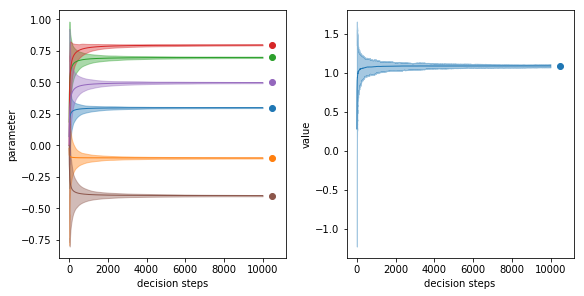

In [21]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

f, (ax1,ax2) = plt.subplots(1, 2, figsize=(8,4), constrained_layout=True)

for i in range(2 * p):
    ax1.plot(beta_bar_m[:, i], lw = 1, color = colors[i])
    ax1.fill_between(np.arange(10000), beta_bar_l[:, i], beta_bar_u[:, i], color = colors[i], alpha = 0.4)
    ax1.scatter(10500, beta_true[i], color = colors[i])
    ax1.set_xlabel("decision steps")
    ax1.set_ylabel("parameter")

ax2.plot(val_hat_m, lw = 1, color = colors[0], label = 'Fit')
ax2.fill_between(np.arange(10000), val_hat_l, val_hat_u, color = colors[0], alpha = 0.4, label = '95% CI')
ax2.scatter(10500, val_true, color = colors[0])
ax2.set_xlabel("decision steps")
ax2.set_ylabel("value")

plt.savefig("linear.pdf")

In [18]:
def MCPlugin(model, T, M):
    beta_bar = np.zeros((M, 2 * p))
    val_hat = np.zeros(M)
    P_se_log = np.zeros((M, 2 * p))
    V_se_log = np.zeros(M)
    P_cp = np.zeros(2 * p)
    V_cp = 0.
    for i in range(M):
        model.Initialize()
        model.SGD(T)
        beta_bar[i, :] = model.beta_bar
        val_hat[i] = model.val_hat
        P_se_log[i, :] = model.se_hat
        V_se_log[i] = model.vse_hat
        P_cover = np.abs(beta_true - model.beta_bar) <= 1.96 * model.se_hat
        V_cover = np.abs(val_true - model.val_hat) <= 1.96 * model.vse_hat
        P_cp += np.array(P_cover, dtype = float)
        V_cp += float(V_cover)
    P_mcsd = np.std(beta_bar, axis = 0)
    V_mcsd = np.std(val_hat, axis = 0)
    P_se = np.mean(P_se_log, axis = 0)
    V_se = np.mean(V_se_log, axis = 0)
    P_cp /= M
    V_cp /= M
    return(beta_bar, val_hat, P_mcsd, P_se, P_cp, V_mcsd, V_se, V_cp)

In [19]:
LinearModel = model(mu = u, generator = LinearGenerator, loss = MSELoss,
                    eps = eps, eps_inf = 0.1, alpha = 0.5, gamma = 0.501)
print(' ' * 25 + '[ b01  b02  b03  b11  b12  b13]  val')
for T in [1000, 10000]: #lr = 0.5*t^(-0.667)
    np.random.seed(0)
    beta_bar, val_hat, P_mcsd, P_se, P_cp, V_mcsd, V_se, V_cp = MCPlugin(LinearModel, T = T, M = 200)
    print('ASE/MCSD at step {:6}:'.format(T), np.round(P_se/P_mcsd, 2), round(V_se/V_mcsd, 2))
    print('CvrgProb at step {:6}:'.format(T), np.round(P_cp, 2), round(V_cp, 2))

                         [ b01  b02  b03  b11  b12  b13]  val
ASE/MCSD at step   1000: [1.   0.84 0.73 0.85 0.82 0.78] 0.96
CvrgProb at step   1000: [0.95 0.94 0.86 0.87 0.84 0.9 ] 0.93
ASE/MCSD at step  10000: [1.02 0.92 0.91 1.04 0.95 0.9 ] 1.01
CvrgProb at step  10000: [0.95 0.94 0.9  0.96 0.94 0.92] 0.93


In [22]:
LinearModel = model(mu = u, generator = LinearGenerator, loss = MSELoss,
                    eps = eps, eps_inf = 0.1, alpha = 0.5, gamma = 0.501)
print(' ' * 25 + '[ b01  b02  b03  b11  b12  b13]  val')
for T in [1000, 10000]: #lr = 0.5*t^(-0.667)
    np.random.seed(0)
    beta_bar, val_hat, P_mcsd, P_se, P_cp, V_mcsd, V_se, V_cp = MCPlugin(LinearModel, T = T, M = 200)
    print('ASE/MCSD at step {:6}:'.format(T), np.round(P_se/P_mcsd, 2), round(V_se/V_mcsd, 2))
    print('CvrgProb at step {:6}:'.format(T), np.round(P_cp, 2), round(V_cp, 2))

                         [ b01  b02  b03  b11  b12  b13]  val
ASE/MCSD at step   1000: [0.97 0.94 0.9  0.89 0.81 0.76] 0.91
CvrgProb at step   1000: [0.94 0.95 0.93 0.89 0.86 0.88] 0.91
ASE/MCSD at step  10000: [1.01 0.98 0.92 1.03 0.9  0.92] 1.01
CvrgProb at step  10000: [0.96 0.95 0.92 0.96 0.92 0.92] 0.93


In [ ]:
# A parallel version of above cells
# eps = 1 for the first 50 steps and then 0.2, lr = 0.5*t^(-0.501)
# M = 5000 replications

#                          [beta01 beta02 beta03 beta11 beta12 beta13]  value
# ASE/MCSD at step   1000: [0.9244 0.9048 0.8606 0.8963 0.7989 0.8337] 0.9095
# CvrgProb at step   1000: [0.9274 0.9332 0.8952 0.8608 0.8902 0.9040] 0.9136
# ASE/MCSD at step  10000: [0.9978 0.9562 0.9606 0.9406 0.9492 0.9280] 0.9885
# CvrgProb at step  10000: [0.9484 0.9408 0.9360 0.9234 0.9314 0.9304] 0.9470
# ASE/MCSD at step 100000: [0.9819 0.9786 0.9751 0.9949 0.9607 1.0019] 1.0134
# CvrgProb at step 100000: [0.9460 0.9452 0.9464 0.9512 0.9352 0.9484] 0.9496

In [2]:
# linear
res1 = [[0.876, 0.821, 0.796, 0.840, 0.815, 0.716, 0.894],
        [0.919, 0.897, 0.875, 0.875, 0.885, 0.888, 0.903],
        [0.059, 0.062, 0.063, 0.049, 0.055, 0.059, 0.068],
        [0.952, 0.904, 0.911, 0.945, 0.910, 0.901, 0.952],
        [0.935, 0.928, 0.924, 0.933, 0.923, 0.923, 0.936],
        [0.015, 0.015, 0.014, 0.011, 0.012, 0.013, 0.021],
        [0.970, 0.973, 0.979, 0.974, 0.992, 0.955, 0.998],
        [0.943, 0.945, 0.945, 0.944, 0.949, 0.940, 0.945],
        [0.005, 0.004, 0.004, 0.003, 0.004, 0.004, 0.007]]
                                                         
res2 = [[0.929, 0.907, 0.882, 0.892, 0.814, 0.854, 0.929],
        [0.933, 0.934, 0.892, 0.857, 0.900, 0.916, 0.911],
        [0.043, 0.045, 0.048, 0.039, 0.045, 0.046, 0.077],
        [0.963, 0.970, 0.957, 0.951, 0.938, 0.924, 1.005],
        [0.938, 0.942, 0.934, 0.926, 0.933, 0.927, 0.945],
        [0.011, 0.011, 0.010, 0.009, 0.009, 0.010, 0.024],
        [0.983, 0.972, 0.961, 0.995, 0.988, 0.993, 1.008],
        [0.947, 0.945, 0.940, 0.948, 0.945, 0.952, 0.948],
        [0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.008]]
                                                         
res3 = [[0.946, 0.911, 0.884, 0.905, 0.825, 0.857, 0.837],
        [0.934, 0.931, 0.894, 0.870, 0.899, 0.916, 0.881],
        [0.045, 0.048, 0.050, 0.040, 0.046, 0.048, 0.068],
        [0.963, 0.924, 0.923, 0.946, 0.929, 0.925, 0.995],
        [0.942, 0.930, 0.924, 0.928, 0.931, 0.928, 0.947],
        [0.014, 0.014, 0.014, 0.011, 0.012, 0.013, 0.021],
        [0.965, 0.975, 0.974, 0.987, 0.975, 0.977, 0.993],
        [0.943, 0.948, 0.944, 0.944, 0.945, 0.946, 0.946],
        [0.005, 0.004, 0.004, 0.003, 0.004, 0.004, 0.007]]
x1 = np.array(res1[::3])
y1 = np.array(res1[1::3])
z1 = np.array(res1[2::3])
x2 = np.array(res2[::3])
y2 = np.array(res2[1::3])
z2 = np.array(res2[2::3])
x3 = np.array(res3[::3])
y3 = np.array(res3[1::3])
z3 = np.array(res3[2::3])

In [5]:
# linear s=0.5
res1 = [[0.830, 0.754, 0.742, 0.855, 0.784, 0.765, 0.883],
        [0.897, 0.864, 0.858, 0.906, 0.865, 0.870, 0.884],
        [0.246, 0.244, 0.234, 0.181, 0.187, 0.206, 0.093],
        [0.962, 0.907, 0.907, 0.937, 0.900, 0.910, 0.983],
        [0.943, 0.920, 0.924, 0.932, 0.924, 0.923, 0.938],
        [0.073, 0.072, 0.068, 0.055, 0.057, 0.062, 0.029],
        [0.975, 0.953, 0.983, 0.970, 0.970, 0.967, 1.008],
        [0.944, 0.938, 0.949, 0.937, 0.941, 0.945, 0.946],
        [0.023, 0.022, 0.021, 0.017, 0.018, 0.019, 0.009]]
                                                         
res2 = [[0.939, 0.889, 0.882, 0.934, 0.910, 0.897, 0.954],
        [0.931, 0.908, 0.908, 0.927, 0.916, 0.911, 0.919],
        [0.169, 0.168, 0.161, 0.133, 0.139, 0.149, 0.100],
        [0.966, 0.957, 0.951, 0.946, 0.942, 0.949, 0.982],
        [0.942, 0.941, 0.937, 0.937, 0.938, 0.936, 0.937],
        [0.052, 0.051, 0.048, 0.040, 0.042, 0.045, 0.032],
        [0.988, 0.987, 0.976, 1.000, 0.997, 0.978, 1.018],
        [0.945, 0.948, 0.945, 0.952, 0.950, 0.947, 0.950],
        [0.016, 0.016, 0.015, 0.013, 0.013, 0.014, 0.010]]
                                                         
res3 = [[0.968, 0.911, 0.902, 0.956, 0.914, 0.906, 0.873],
        [0.940, 0.916, 0.911, 0.932, 0.920, 0.914, 0.896],
        [0.187, 0.184, 0.177, 0.144, 0.149, 0.162, 0.093],
        [0.950, 0.924, 0.921, 0.944, 0.930, 0.927, 0.976],
        [0.940, 0.929, 0.931, 0.932, 0.931, 0.924, 0.941],
        [0.071, 0.069, 0.065, 0.053, 0.055, 0.060, 0.029],
        [1.000, 0.975, 0.994, 0.980, 0.970, 0.959, 0.983],
        [0.954, 0.941, 0.949, 0.945, 0.943, 0.941, 0.943],
        [0.023, 0.022, 0.021, 0.017, 0.018, 0.019, 0.009]]
x1 = np.array(res1[::3])
y1 = np.array(res1[1::3])
z1 = np.array(res1[2::3])
x2 = np.array(res2[::3])
y2 = np.array(res2[1::3])
z2 = np.array(res2[2::3])
x3 = np.array(res3[::3])
y3 = np.array(res3[1::3])
z3 = np.array(res3[2::3])

In [3]:
# logistic
res1 = [[1.071, 1.033, 1.063, 1.011, 0.994, 1.007, 0.671],
        [0.962, 0.954, 0.945, 0.923, 0.898, 0.910, 0.717],
        [0.963, 0.977, 0.960, 0.708, 0.795, 0.846, 0.061],
        [0.947, 0.925, 0.919, 0.953, 0.919, 0.922, 0.878],
        [0.939, 0.934, 0.929, 0.941, 0.923, 0.925, 0.840],
        [0.308, 0.312, 0.319, 0.224, 0.275, 0.287, 0.019],
        [0.979, 0.963, 0.974, 0.994, 0.966, 0.987, 0.961],
        [0.948, 0.941, 0.939, 0.948, 0.944, 0.950, 0.923],
        [0.097, 0.097, 0.100, 0.070, 0.088, 0.091, 0.006]]
                                                         
res2 = [[1.037, 1.029, 1.016, 0.968, 0.992, 1.013, 0.816],
        [0.955, 0.954, 0.909, 0.849, 0.876, 0.909, 0.814],
        [0.675, 0.684, 0.669, 0.521, 0.583, 0.614, 0.066],
        [0.948, 0.924, 0.921, 0.940, 0.922, 0.924, 0.951],
        [0.940, 0.926, 0.927, 0.929, 0.924, 0.926, 0.905],
        [0.219, 0.220, 0.225, 0.166, 0.199, 0.206, 0.021],
        [0.978, 0.966, 0.969, 0.993, 0.967, 0.970, 0.974],
        [0.945, 0.945, 0.939, 0.946, 0.944, 0.945, 0.936],
        [0.069, 0.069, 0.072, 0.053, 0.064, 0.066, 0.007]]
                                                          
res3 = [[1.117, 1.127, 1.127, 1.058, 1.059, 1.101, 0.781],
        [0.967, 0.973, 0.944, 0.885, 0.899, 0.927, 0.792],
        [0.753, 0.758, 0.739, 0.566, 0.635, 0.676, 0.060],
        [0.975, 0.944, 0.948, 0.960, 0.962, 0.954, 0.936],
        [0.943, 0.938, 0.935, 0.942, 0.937, 0.935, 0.886],
        [0.298, 0.301, 0.306, 0.218, 0.266, 0.278, 0.019],
        [0.976, 0.963, 0.978, 0.969, 0.953, 0.966, 0.991],
        [0.944, 0.940, 0.935, 0.940, 0.935, 0.937, 0.939],
        [0.096, 0.097, 0.100, 0.070, 0.087, 0.091, 0.006]]
x1 = np.array(res1[::3])
y1 = np.array(res1[1::3])
z1 = np.array(res1[2::3])
x2 = np.array(res2[::3])
y2 = np.array(res2[1::3])
z2 = np.array(res2[2::3])
x3 = np.array(res3[::3])
y3 = np.array(res3[1::3])
z3 = np.array(res3[2::3])

In [3]:
def cvrt(x):
    return np.dstack((np.mean(x[:, :-1], axis = 1), x[:, -1])).squeeze()
cvrt(x1)

array([[0.81066667, 0.894     ],
       [0.9205    , 0.952     ],
       [0.97383333, 0.998     ]])

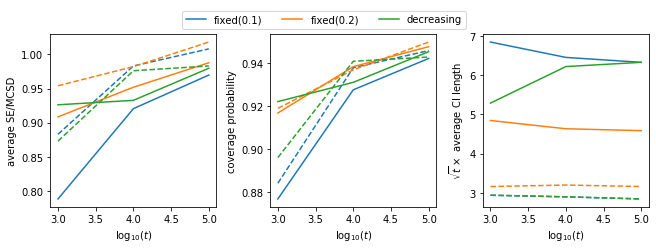

In [6]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

f, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(9,3), constrained_layout=True)
x = np.array([cvrt(x1), cvrt(x2), cvrt(x3)])
y = np.array([cvrt(y1), cvrt(y2), cvrt(y3)])
z = np.array([cvrt(z1), cvrt(z2), cvrt(z3)])
T = [1000, 10000, 100000]
estimator = ['fixed(0.1)', 'fixed(0.2)', 'decreasing']
linestyle = ['-', '--']
for i in range(3):
    for j in range(2):
        if j == 0:
            ax1.plot(np.log10(T), x[i, :, j], color = colors[i], linestyle = linestyle[j], label = estimator[i])
        else:
            ax1.plot(np.log10(T), x[i, :, j], color = colors[i], linestyle = linestyle[j])
        ax2.plot(np.log10(T), y[i, :, j], color = colors[i], linestyle = linestyle[j])
        ax3.plot(np.log10(T), np.sqrt(T) * z[i, :, j], color = colors[i], linestyle = linestyle[j])
ax1.set_xlabel(r"$\log_{10}(t)$")
ax1.set_ylabel("average SE/MCSD")
ax2.set_xlabel(r"$\log_{10}(t)$")
ax2.set_ylabel("coverage probability")
ax3.set_xlabel(r"$\log_{10}(t)$")
ax3.set_ylabel("$\sqrt{t}\\times$ average CI length")
f.legend(bbox_to_anchor=(0.5,1.02), loc="lower center", borderaxespad=0, ncol=3)
plt.savefig("linear_s5_exploration_rev.pdf", bbox_inches='tight')

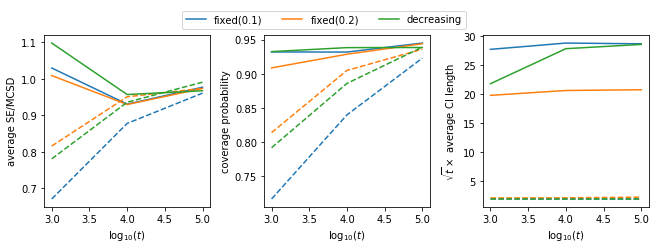

In [10]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

f, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(9,3), constrained_layout=True)
x = np.array([cvrt(x1), cvrt(x2), cvrt(x3)])
y = np.array([cvrt(y1), cvrt(y2), cvrt(y3)])
z = np.array([cvrt(z1), cvrt(z2), cvrt(z3)])
T = [1000, 10000, 100000]
estimator = ['fixed(0.1)', 'fixed(0.2)', 'decreasing']
linestyle = ['-', '--']
for i in range(3):
    for j in range(2):
        if j == 0:
            ax1.plot(np.log10(T), x[i, :, j], color = colors[i], linestyle = linestyle[j], label = estimator[i])
        else:
            ax1.plot(np.log10(T), x[i, :, j], color = colors[i], linestyle = linestyle[j])
        ax2.plot(np.log10(T), y[i, :, j], color = colors[i], linestyle = linestyle[j])
        ax3.plot(np.log10(T), np.sqrt(T) * z[i, :, j], color = colors[i], linestyle = linestyle[j])
ax1.set_xlabel(r"$\log_{10}(t)$")
ax1.set_ylabel("average SE/MCSD")
ax2.set_xlabel(r"$\log_{10}(t)$")
ax2.set_ylabel("coverage probability")
ax3.set_xlabel(r"$\log_{10}(t)$")
ax3.set_ylabel("$\sqrt{t}\\times$ average CI length")
f.legend(bbox_to_anchor=(0.5,1.02), loc="lower center", borderaxespad=0, ncol=3)
plt.savefig("logistic_exploration_rev.pdf", bbox_inches='tight')

In [19]:
def MCPluginF(model, T, M):
    beta_bar = np.zeros((M, 2 * p))
    val_hat = np.zeros(M)
    P_se_log = np.zeros((M, 2 * p))
    V_ose_log = np.zeros(M)
    V_fse_log = np.zeros(M)
    P_cp = np.zeros(2 * p)
    V_ocp = 0.
    V_fcp = 0.
    for i in range(M):
        model.Initialize()
        model.SGD(T)
        beta_bar[i, :] = model.beta_bar
        val_hat[i] = model.val_hat
        P_se_log[i, :] = model.se_hat
        V_ose_log[i] = model.vse_hat
        V_fse_log[i] = np.sqrt(model.PluginValueVariance()/model.step)
        P_cover = np.abs(beta_true - model.beta_bar) <= 1.96 * model.se_hat
        V_ocover = np.abs(val_true - model.val_hat) <= 1.96 * model.vse_hat
        V_fcover = np.abs(val_true - model.val_hat) <= 1.96 * V_fse_log[i]
        P_cp += np.array(P_cover, dtype=float)
        V_ocp += float(V_ocover)
        V_fcp += float(V_fcover)
    P_mcsd = np.std(beta_bar, axis = 0)
    V_mcsd = np.std(val_hat, axis = 0)
    P_se = np.mean(P_se_log, axis = 0)
    V_ose = np.mean(V_ose_log, axis = 0)
    V_fse = np.mean(V_fse_log, axis = 0)
    P_cp /= M
    V_ocp /= M
    V_fcp /= M
    return(beta_bar, val_hat, P_mcsd, P_se, P_cp, V_mcsd, V_ose, V_ocp, V_fse, V_fcp)

In [117]:
LinearModel = model(mu = u, generator = LinearGenerator, loss = MSELoss,
                    eps = eps, eps_inf = 0.05, alpha = 0.5, gamma = 2/3)
print(' ' * 25 + '[ b01  b02  b03  b11  b12  b13] onln finl')
for T in [1000, 10000, 100000]: #lr = 0.5*t^(-0.667)
    np.random.seed(0)
    beta_bar, val_hat, P_mcsd, P_se, P_cp, V_mcsd, V_ose, V_ocp, V_fse, V_fcp = MCPluginF(LinearModel, T = T, M = 200)
    print('ASE/MCSD at step {:6}:'.format(T), np.round(P_se/P_mcsd, 2), 
          round(V_ose/V_mcsd, 2), round(V_fse/V_mcsd, 2))
    print('CvrgProb at step {:6}:'.format(T), np.round(P_cp, 2),
          round(V_ocp, 2), round(V_fcp, 2))

                         [ b01  b02  b03  b11  b12  b13] onln finl
ASE/MCSD at step   1000: [0.83 0.54 0.6  0.39 0.52 0.36] 0.71 0.65
CvrgProb at step   1000: [0.9  0.84 0.85 0.76 0.7  0.77] 0.86 0.82
ASE/MCSD at step  10000: [0.54 0.41 0.79 0.73 0.7  0.72] 0.97 0.92
CvrgProb at step  10000: [0.92 0.89 0.87 0.9  0.88 0.88] 0.94 0.93
ASE/MCSD at step 100000: [0.99 1.01 0.96 0.91 0.93 1.02] 1.03 0.98
CvrgProb at step 100000: [0.94 0.94 0.94 0.92 0.94 0.95] 0.94 0.9


# Simulation Study -- Logistic Model Setting
Code reward as $Y = \pm 1$. Its pmf is modeled by
$$
P(Y = y | A, X; \beta) = \frac{1}{1+e^{-yu(A, X, \beta)}},
$$
where $u(\cdot)$ is a linear function of $\beta$. Consider the logistic loss function
$$
\ell(\beta; O) = \log[1 + \exp\{-Y u(A, X; \beta)\}].
$$
The gradient is 
$$
\nabla\ell(\beta; O) = -\frac{Y\nabla u(A, X, \beta)}{1 + \exp\{Y u(A, X; \beta)\}}
$$
and 
$$
\nabla^2 \ell(\beta) = \frac{\exp\{Y u(A, X; \beta)\}\nabla u(A, X, \beta)\{\nabla u(A, X, \beta)\}^T}{[1 + \exp\{Y u(A, X; \beta)\}]^2}
$$

## Evaluation of the truth
Pure exploration for the first 20 step, then $\varepsilon_t = \varepsilon_\infty = 0.05$. Learning rate is $0.5t^{-2/3}$.

In [15]:
LogisticModel = model(mu = logit, generator = LogisticGenerator, loss = LogisticLoss,
                      eps = eps, eps_inf = 0.05, alpha = 0.5, gamma = 0.501)

N = 1000000
X, _ = LogisticGenerator(N)
A = np.random.binomial(1, 0.5, N)
O = LogisticGenerator(N, X, A, True)
_, H = LogisticLoss(beta_true, O, return_second_moment=True)
epsilon = 0.05
d = np.array(logit(1, X, beta_true) > logit(0, X, beta_true), dtype = float)
pi = (1 - epsilon) * d + epsilon/2
U0 = u(0, X, beta_true)
U1 = u(1, X, beta_true)
Y0 = (np.random.binomial(1, sigmoid(U0)) - 0.5) * 2
Y1 = (np.random.binomial(1, sigmoid(U1)) - 0.5) * 2
den0 = (1 + np.exp(Y0 * U0))**2
den1 = (1 + np.exp(Y1 * U1))**2
from scipy.linalg import block_diag
S = block_diag(np.dot(X.T/(1-pi)/den0, X), np.dot(X.T/pi/den1, X))/(4 * N)
H_inv = np.linalg.inv(H)
V = np.dot(np.dot(H_inv, S), H_inv)
val_true = np.mean(logit(d, X, beta_true))
VV = 2/(2 - epsilon) - val_true**2

## Consistency of plugin estimator

In [75]:
# Plugin Method
print('True beta    :', np.round(beta_true, 3))
print('TSE * sqrt(t):', np.round(np.sqrt(np.diag(V)), 3))
LogisticModel.Initialize()
for T in [1000, 9000, 90000, 900000, 1000000, 1000000]:
    LogisticModel.SGD(T)
    print('Step {:8}:'.format(LogisticModel.step))
    print('beta estimate:', np.round(LogisticModel.beta_bar, 3))
    print('PSE * sqrt(t):', np.round(LogisticModel.se_hat * np.sqrt(LogisticModel.step), 3))
    print('H estimate   :', np.round(np.diag(LogisticModel.H_hat/LogisticModel.step), 3))
    print('S estimate   :', np.round(np.diag(LogisticModel.S_hat/LogisticModel.step), 3))

True beta    : [ 0.3 -0.1  0.7  0.8  0.5 -0.4]
TSE * sqrt(t): [10.91  10.978 11.253  7.687  9.78  10.218]
Step     1000:
beta estimate: [-0.049 -0.315  1.202  0.438  0.449 -0.691]
PSE * sqrt(t): [11.91  18.277 15.418  7.753  8.63   9.067]
H estimate   : [0.109 0.09  0.071 0.129 0.112 0.112]
S estimate   : [1.661 2.732 1.321 1.442 0.949 1.432]
Step    10000:
beta estimate: [ 0.229 -0.082  0.703  0.593  0.387 -0.622]
PSE * sqrt(t): [10.453 11.467 12.942  8.375 10.787  9.881]
H estimate   : [0.11  0.1   0.09  0.118 0.107 0.112]
S estimate   : [1.384 1.258 1.418 1.4   1.3   1.513]
Step   100000:
beta estimate: [ 0.326 -0.092  0.645  0.777  0.506 -0.436]
PSE * sqrt(t): [10.625 10.865 11.11   8.057 10.152 10.254]
H estimate   : [0.111 0.109 0.096 0.104 0.095 0.101]
S estimate   : [1.512 1.41  1.26  0.987 0.962 1.239]
Step  1000000:
beta estimate: [ 0.293 -0.121  0.695  0.789  0.494 -0.408]
PSE * sqrt(t): [10.884 10.919 11.232  7.78   9.938 10.302]
H estimate   : [0.11  0.109 0.092 0.101 0.09

In [76]:
print('H:')
print(np.round(H, 3))
print('H_hat:')
print(np.round(LogisticModel.H_hat/LogisticModel.step, 3))
print('S:')
print(np.round(S, 3))
print('S_hat:')
print(np.round(LogisticModel.S_hat/LogisticModel.step, 3))

H:
[[ 0.11   0.001 -0.009  0.     0.     0.   ]
 [ 0.001  0.11   0.003  0.     0.     0.   ]
 [-0.009  0.003  0.091  0.     0.     0.   ]
 [ 0.     0.     0.     0.101 -0.015  0.012]
 [ 0.     0.     0.    -0.015  0.095  0.006]
 [ 0.     0.     0.     0.012  0.006  0.097]]
H_hat:
[[ 0.111  0.001 -0.009  0.     0.     0.   ]
 [ 0.001  0.11   0.003  0.     0.     0.   ]
 [-0.009  0.003  0.092  0.     0.     0.   ]
 [ 0.     0.     0.     0.102 -0.015  0.013]
 [ 0.     0.     0.    -0.015  0.095  0.006]
 [ 0.     0.     0.     0.013  0.006  0.097]]
S:
[[ 1.559  0.391 -0.699  0.     0.     0.   ]
 [ 0.391  1.467  0.154  0.     0.     0.   ]
 [-0.699  0.154  1.139  0.     0.     0.   ]
 [ 0.     0.     0.     0.855 -0.434  0.75 ]
 [ 0.     0.     0.    -0.434  0.912 -0.148]
 [ 0.     0.     0.     0.75  -0.148  1.096]]
S_hat:
[[ 1.559  0.392 -0.711  0.     0.     0.   ]
 [ 0.392  1.465  0.162  0.     0.     0.   ]
 [-0.711  0.162  1.177  0.     0.     0.   ]
 [ 0.     0.     0.     0.869 -0

In [77]:
print(' ' * 14 + 'Value VSE*rt')
print('True       : {:6} {:6}'.format(round(val_true, 4), round(np.sqrt(VV), 4)))
LogisticModel.Initialize()
np.random.seed(2)
for T in [1000, 9000, 90000]:
    LogisticModel.SGD(T)
    print('Step {:6}: {:6} {:6}'.format(LogisticModel.step, 
        np.round(LogisticModel.val_hat, 4), 
        np.round(LogisticModel.vse_hat * np.sqrt(LogisticModel.step), 4)))

              Value VSE*rt
True       : 0.4774 0.8932
Step   1000: 0.4786 0.8945
Step  10000: 0.4499 0.9059
Step 100000: 0.4749 0.8945


## Learning rate tuning

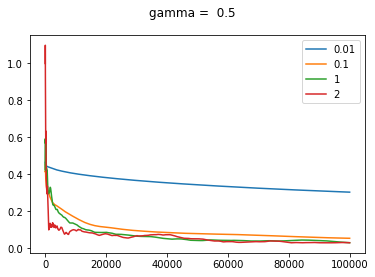

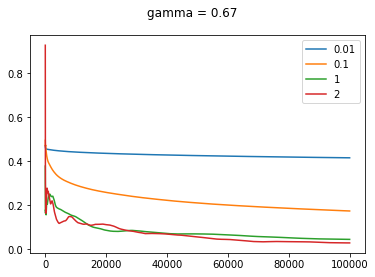

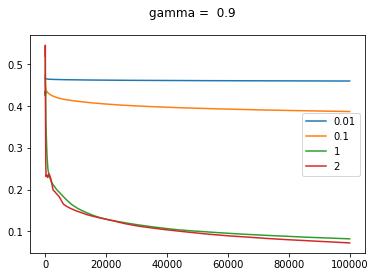

In [63]:
for gamma in [0.501, 2/3, 0.9]:
    fig = plt.figure()
    fig.suptitle("gamma = {:4}".format(round(gamma, 3)))
    for alpha in [0.01, 0.1, 1, 2]:
        LogisticModel = model(mu = logit, generator = LogisticGenerator, loss = LogisticLoss,
                              eps = eps, eps_inf = 0.05, alpha = alpha, gamma = gamma)
        LogisticModel.Initialize()
        LogisticModel.SGD(100000)
        MAE = [np.mean(np.abs(beta-beta_true)) for beta in LogisticModel.beta_bar_log[1:]]
        plt.plot(MAE, label = str(alpha))
    plt.legend()
    plt.show()

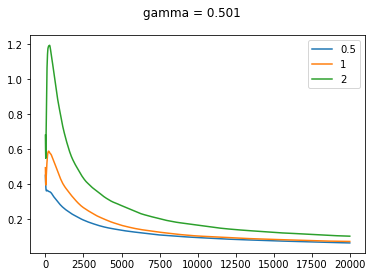

In [66]:
T = 20000
M = 100
fig = plt.figure()
fig.suptitle("gamma = 0.501")
for alpha in [0.5, 1, 2]:
    LogisticModel = model(mu = logit, generator = LogisticGenerator, loss = LogisticLoss,
                          eps = eps, eps_inf = 0.05, alpha = alpha, gamma = 0.501)
    MAE = np.zeros(T)
    for _ in range(M):
        LogisticModel.Initialize()
        LogisticModel.SGD(T)
        MAE += [np.mean(np.abs(beta-beta_true)) for beta in LogisticModel.beta_bar_log[1:]]
    MAE /= M
    plt.plot(MAE, label = str(alpha))
plt.legend()
plt.show()

## Monte Carlo experiments

In [78]:
LogisticModel = model(mu = logit, generator = LogisticGenerator, loss = LogisticLoss,
                      eps = eps, eps_inf = 0.05, alpha = 0.5, gamma = 0.501)
print(' ' * 25 + '[ b01  b02  b03  b11  b12  b13]  val')
for T in [1000, 10000, 100000]: #lr = 0.5*t^(-0.501)
    np.random.seed(2)
    beta_bar, V, P_mcsd, P_se, P_cp, V_mcsd, V_se, V_cp = MCPlugin(LogisticModel, T = T, M = 200)
    print('ASE/MCSD at step {:6}:'.format(T), np.round(P_se/P_mcsd, 2), round(V_se/V_mcsd, 2))
    print('CvrgProb at step {:6}:'.format(T), np.round(P_cp, 2), round(V_cp, 2))

                         [ b01  b02  b03  b11  b12  b13]  val
ASE/MCSD at step   1000: [0.94 1.   0.93 0.88 0.91 0.81] 0.43
CvrgProb at step   1000: [0.96 0.94 0.92 0.94 0.89 0.84] 0.47
ASE/MCSD at step  10000: [0.98 0.94 0.9  0.87 0.91 0.82] 0.65
CvrgProb at step  10000: [0.96 0.95 0.92 0.91 0.95 0.9 ] 0.58
ASE/MCSD at step 100000: [1.05 0.99 0.97 1.02 1.07 0.99] 0.87
CvrgProb at step 100000: [0.98 0.94 0.9  0.95 0.94 0.95] 0.85


In [20]:
LogisticModel = model(mu = logit, generator = LogisticGenerator, loss = LogisticLoss,
                      eps = eps, eps_inf = 0.05, alpha = 0.5, gamma = 0.501)
print(' ' * 25 + '[ b01  b02  b03  b11  b12  b13] onln finl')
for T in [1000, 10000, 100000]: #lr = 0.5*t^(-0.501)
    np.random.seed(0)
    beta_bar, val_hat, P_mcsd, P_se, P_cp, V_mcsd, V_ose, V_ocp, V_fse, V_fcp = MCPluginF(LogisticModel, T = T, M = 200)
    print('ASE/MCSD at step {:6}:'.format(T), np.round(P_se/P_mcsd, 2), 
          round(V_ose/V_mcsd, 2), round(V_fse/V_mcsd, 2))
    print('CvrgProb at step {:6}:'.format(T), np.round(P_cp, 2),
          round(V_ocp, 2), round(V_fcp, 2))

                         [ b01  b02  b03  b11  b12  b13] onln finl
ASE/MCSD at step   1000: [1.02 1.01 1.01 0.94 0.83 0.71] 0.43 0.41
CvrgProb at step   1000: [0.96 0.96 0.94 0.94 0.89 0.9 ] 0.51 0.49
ASE/MCSD at step  10000: [0.98 0.9  0.81 0.91 0.92 0.83] 0.6 0.59
CvrgProb at step  10000: [0.96 0.92 0.88 0.91 0.93 0.9 ] 0.55 0.55
ASE/MCSD at step 100000: [0.99 0.92 0.99 1.02 1.01 0.94] 0.84 0.84
CvrgProb at step 100000: [0.94 0.92 0.9  0.96 0.94 0.9 ] 0.81 0.8


# Simulation Study -- Logistic Model Setting 2
Code reward as $Y = 0, 1$. Its pmf is modeled by
$$
\mu = P(Y = 1 | A, X; \beta) = \frac{1}{1+e^{-u(A, X, \beta)}},
$$
where $u(\cdot)$ is a linear function of $\beta$. Consider the cross entrophy loss function
$$
\ell(\beta; O) = -Y\log\mu - (1 - Y)\log(1-\mu).
$$
The gradient is 
$$
\nabla\ell(\beta; O) = (\mu - Y)\nabla u(A, X, \beta)
$$
and 
$$
\nabla^2 \ell(\beta) = (\mu - Y)^2\nabla u(A, X, \beta)\{\nabla u(A, X, \beta)\}^T
$$

## Evaluation of the truth
Pure exploration for the first 50 step, then $\varepsilon_t = \varepsilon_\infty = 0.2$. Learning rate is $0.5t^{-0.501}$.

In [32]:
def eps(t):
    if t < 50:
        return(1)
    else:
        return(0.1)

In [33]:
LogisticModel01 = model(mu = logit01, generator = LogisticGenerator01, loss = BCELoss,
                        eps = eps, eps_inf = 0.1, alpha = 0.5, gamma = 0.501)

N = 1000000
X, _ = LogisticGenerator01(N)
A = np.random.binomial(1, 0.5, N)
O = LogisticGenerator01(N, X, A, True)
_, H = BCELoss(beta_true, O, return_second_moment=True)
epsilon = 0.1
mu0 = logit01(0, X, beta_true)
mu1 = logit01(1, X, beta_true)
d = np.array(mu1 > mu0, dtype = float)
pi = (1 - epsilon) * d + epsilon/2
from scipy.linalg import block_diag
S = block_diag(np.dot(X.T * (mu0 - mu0**2)/(1-pi), X), np.dot(X.T * (mu1 - mu1**2)/pi, X))/(4 * N)
H_inv = np.linalg.inv(H)
V = np.dot(np.dot(H_inv, S), H_inv)
val_true = np.mean(logit01(d, X, beta_true))
VV = val_true * 2/(2 - epsilon) - val_true**2

## Consistency of plugin estimator

In [25]:
# Plugin Method
print('True beta    :', np.round(beta_true, 3))
print('TSE * sqrt(t):', np.round(np.sqrt(np.diag(V)), 3))
LogisticModel01.Initialize()
for T in [1000, 9000, 90000, 900000, 1000000, 1000000]:
    LogisticModel01.SGD(T)
    print('Step {:8}:'.format(LogisticModel01.step))
    print('beta estimate:', np.round(LogisticModel01.beta_bar, 3))
    print('PSE * sqrt(t):', np.round(LogisticModel01.se_hat * np.sqrt(LogisticModel01.step), 3))
    print('H estimate   :', np.round(np.diag(LogisticModel01.H_hat/LogisticModel01.step), 3))
    print('S estimate   :', np.round(np.diag(LogisticModel01.S_hat/LogisticModel01.step), 3))

True beta    : [ 0.3 -0.1  0.7  0.8  0.5 -0.4]
TSE * sqrt(t): [24.233 24.325 24.982 16.777 21.63  22.545]
Step     1000:
beta estimate: [ 0.052 -0.092  1.184  0.565  0.591 -0.55 ]
PSE * sqrt(t): [ 9.823 10.867  7.471  9.06  10.161  9.694]
H estimate   : [0.103 0.12  0.082 0.136 0.103 0.151]
S estimate   : [1.065 1.772 0.368 1.986 1.314 2.67 ]
Step    10000:
beta estimate: [ 0.256 -0.317  0.833  0.976  0.449 -0.342]
PSE * sqrt(t): [21.824 21.809 22.701 14.682 20.14  22.074]
H estimate   : [0.112 0.12  0.063 0.084 0.082 0.074]
S estimate   : [6.338 7.699 1.971 1.726 2.541 2.503]
Step   100000:
beta estimate: [ 0.296 -0.094  0.777  0.769  0.58  -0.433]
PSE * sqrt(t): [23.66  24.037 24.328 18.098 25.095 24.985]
H estimate   : [0.11  0.104 0.082 0.098 0.089 0.09 ]
S estimate   : [7.173 6.268 4.347 4.541 5.157 5.423]
Step  1000000:
beta estimate: [ 0.293 -0.121  0.712  0.792  0.512 -0.42 ]
PSE * sqrt(t): [24.021 24.487 25.832 17.265 22.312 22.902]
H estimate   : [0.11  0.107 0.089 0.101 0.09

In [26]:
print('H:')
print(np.round(H, 3))
print('H_hat:')
print(np.round(LogisticModel01.H_hat/LogisticModel01.step, 3))
print('S:')
print(np.round(S, 3))
print('S_hat:')
print(np.round(LogisticModel01.S_hat/LogisticModel01.step, 3))

H:
[[ 0.11   0.001 -0.009  0.     0.     0.   ]
 [ 0.001  0.11   0.003  0.     0.     0.   ]
 [-0.009  0.003  0.091  0.     0.     0.   ]
 [ 0.     0.     0.     0.101 -0.015  0.012]
 [ 0.     0.     0.    -0.015  0.094  0.005]
 [ 0.     0.     0.     0.012  0.005  0.097]]
H_hat:
[[ 0.111  0.001 -0.009  0.     0.     0.   ]
 [ 0.001  0.108  0.004  0.     0.     0.   ]
 [-0.009  0.004  0.091  0.     0.     0.   ]
 [ 0.     0.     0.     0.101 -0.015  0.012]
 [ 0.     0.     0.    -0.015  0.093  0.006]
 [ 0.     0.     0.     0.012  0.006  0.094]]
S:
[[ 7.725  1.982 -3.564  0.     0.     0.   ]
 [ 1.982  7.251  0.783  0.     0.     0.   ]
 [-3.564  0.783  5.642  0.     0.     0.   ]
 [ 0.     0.     0.     4.154 -2.19   3.812]
 [ 0.     0.     0.    -2.19   4.469 -0.781]
 [ 0.     0.     0.     3.812 -0.781  5.415]]
S_hat:
[[ 7.763  2.08  -3.65   0.     0.     0.   ]
 [ 2.08   7.083  0.777  0.     0.     0.   ]
 [-3.65   0.777  5.807  0.     0.     0.   ]
 [ 0.     0.     0.     4.233 -2

In [34]:
print(' ' * 14 + 'Value VSE*rt')
print('True       : {:6} {:6}'.format(round(val_true, 4), round(np.sqrt(VV), 4)))
LogisticModel01.Initialize()
np.random.seed(2)
for T in [1000, 9000, 90000]:
    LogisticModel01.SGD(T)
    print('Step {:6}: {:6} {:6}'.format(LogisticModel01.step, 
        np.round(LogisticModel01.val_hat, 4), 
        np.round(LogisticModel01.vse_hat * np.sqrt(LogisticModel01.step), 4)))

              Value VSE*rt
True       : 0.7387 0.4816
Step   1000: 0.7229 0.4882
Step  10000: 0.7203 0.4893
Step 100000:  0.737 0.4823


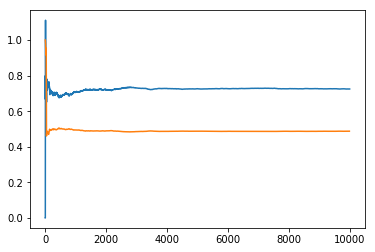

In [39]:
LogisticModel01.Initialize()
np.random.seed()
vse_hat_log = []
for _ in range(1000):
    LogisticModel01.SGD(10)
    vse_hat_log.append(LogisticModel01.vse_hat * np.sqrt(LogisticModel01.step))
#fig = plt.figure()
plt.plot(LogisticModel01.val_hat_log, label = 'val')
plt.plot(range(0,10000,10), vse_hat_log, label = 'vse*rt')
#plt.legend()
#plt.show()

## Monte Carlo experiments

In [ ]:
def eps(t):
    return 1 if t < 50 else 0.1
LogisticModel01 = model(mu = logit01, generator = LogisticGenerator01, loss = BCELoss,
                        eps = eps, eps_inf = 0.1, alpha = 0.5, gamma = 0.501)
print(' ' * 25 + '[ b01  b02  b03  b11  b12  b13]  val')
for T in [1000, 10000, 100000]:
    np.random.seed(2)
    beta_bar, V, P_mcsd, P_se, P_cp, V_mcsd, V_se, V_cp = MCPlugin(LogisticModel01, T = T, M = 200)
    print('ASE/MCSD at step {:6}:'.format(T), np.round(P_se/P_mcsd, 2), round(V_se/V_mcsd, 2))
    print('CvrgProb at step {:6}:'.format(T), np.round(P_cp, 2), round(V_cp, 2))

In [ ]:
# A parallel version of above cells
# eps = 1 for the first 50 steps and then 0.2, lr = 0.5*t^(-0.501)
# M = 5000 replications

#                          [beta01 beta02 beta03 beta11 beta12 beta13]  value
# ASE/MCSD at step   1000: [1.0313 1.0145 0.9992 0.9874 0.9806 1.0084] 0.8189
# CvrgProb at step   1000: [0.9590 0.9550 0.9060 0.8462 0.8736 0.9064] 0.8080
# ASE/MCSD at step  10000: [0.9549 0.9373 0.9248 0.9504 0.9160 0.9356] 0.9608
# CvrgProb at step  10000: [0.9376 0.9330 0.9284 0.9322 0.9208 0.9268] 0.9166
# ASE/MCSD at step 100000: [0.9979 0.9790 0.9922 0.9884 0.9703 0.9756] 0.9731
# CvrgProb at step 100000: [0.9476 0.9438 0.9494 0.9474 0.9450 0.9458] 0.9384

In [27]:
def MCPluginV(model, T, M):
    val_hat = np.zeros(M)
    V_ose_log = np.zeros(M)
    V_fse_log = np.zeros(M)
    V_tse_log = np.zeros(M)
    V_ocp = 0.
    V_fcp = 0.
    V_tcp = 0.
    for i in range(M):
        model.Initialize()
        model.SGD(T)
        val_hat[i] = model.val_hat
        V_ose_log[i] = model.vse_hat
        v1, v2 = model.PluginValueVariance()
        V_fse_log[i] = np.sqrt(v1/model.step)
        V_tse_log[i] = np.sqrt(v2/model.step)
        V_ocover = np.abs(val_true - model.val_hat) <= 1.96 * model.vse_hat
        V_fcover = np.abs(val_true - model.val_hat) <= 1.96 * V_fse_log[i]
        V_tcover = np.abs(val_true - model.val_hat) <= 1.96 * V_tse_log[i]
        V_ocp += float(V_ocover)
        V_fcp += float(V_fcover)
        V_tcp += float(V_tcover)
    V_mcsd = np.std(val_hat, axis = 0)
    V_ose = np.mean(V_ose_log, axis = 0)
    V_fse = np.mean(V_fse_log, axis = 0)
    V_tse = np.mean(V_tse_log, axis = 0)
    V_ocp /= M
    V_fcp /= M
    V_tcp /= M
    return(V_mcsd, V_ose, V_ocp, V_fse, V_fcp, V_tse, V_tcp)

In [45]:
def eps(t):
    return 1 if t < 50 else 0.1
LogisticModel01 = model(mu = logit01, generator = LogisticGenerator01, loss = BCELoss,
                        eps = eps, eps_inf = 0.1, alpha = 0.5, gamma = 0.501)
print(' ' * 25 + 'onln finl true asym')
for T in [100, 1000]: #lr = 0.5*t^(-0.501)
    np.random.seed(0)
    V_mcsd, V_ose, V_ocp, V_fse, V_fcp, V_tse, V_tcp = MCPluginV(LogisticModel01, T = T, M = 100)
    print('ASE/MCSD at step {:6}:'.format(T), round(V_ose/V_mcsd, 2), round(V_fse/V_mcsd, 2), round(V_tse/V_mcsd, 2), round(np.sqrt(VV/T)/V_mcsd, 2))
    print('CvrgProb at step {:6}:'.format(T), round(V_ocp, 2), round(V_fcp, 2), round(V_tcp, 2))

                         onln finl true asym
ASE/MCSD at step    100: 0.64 0.62 0.6 0.62
CvrgProb at step    100: 0.68 0.67 0.67
ASE/MCSD at step   1000: 0.75 0.77 0.73 0.74
CvrgProb at step   1000: 0.77 0.79 0.76


In [31]:
def eps(t):
    return 1 if t < 50 else 0.1
LinearModel = model(mu = u, generator = LinearGenerator, loss = MSELoss,
                    eps = eps, eps_inf = 0.1, alpha = 0.5, gamma = 0.501)
print(' ' * 25 + 'onln finl true asym')
for T in [100, 1000]: #lr = 0.5*t^(-0.501)
    np.random.seed(0)
    V_mcsd, V_ose, V_ocp, V_fse, V_fcp, V_tse, V_tcp = MCPluginV(LinearModel, T = T, M = 100)
    print('ASE/MCSD at step {:6}:'.format(T), round(V_ose/V_mcsd, 2), round(V_fse/V_mcsd, 2), round(V_tse/V_mcsd, 2), round(V_tse/V_mcsd, 2))
    print('CvrgProb at step {:6}:'.format(T), round(V_ocp, 2), round(V_fcp, 2), round(V_tcp, 2))

                         onln finl true
ASE/MCSD at step    100: 0.55 0.52 0.54
CvrgProb at step    100: 0.63 0.59 0.6
ASE/MCSD at step   1000: 0.91 0.92 0.93
CvrgProb at step   1000: 0.91 0.91 0.91


# Real Data

In [15]:
import pandas as pd

In [16]:
data = pd.read_csv("yahoo.csv")
p = 5
data['match'] = 0
data.head()

,Y,A,X1,X2,X3,X4,X5,match
0,0,1,1,0.002340,0.016375,0.067361,0.859867,0
1,1,0,1,0.005462,0.058756,0.922599,0.000025,0
2,0,0,1,0.128593,0.074589,0.171554,0.000253,0
3,0,1,1,0.000006,0.003734,0.003554,0.991892,0
4,0,1,1,0.000035,0.000077,0.000154,0.998665,0


In [17]:
np.sum(data.Y)/data.shape[0]

0.047089344843897825

In [18]:
import statsmodels.api as sm

In [45]:
beta0_real = np.array([-2.8, -0.4, -0.4, 0.1, -1.1])
beta1_real = np.array([-2.6, -0.2, -0.4, -0.2, -1.1])
X = data.loc[:, 'X1':'X5'].to_numpy()
data['Areal'] = np.array(X.dot(beta1_real) > X.dot(beta0_real), dtype = int)[:]
data.head()

,Y,A,X1,X2,X3,X4,X5,match,Areal
0,0,1,1,0.002340,0.016375,0.067361,0.859867,0,1
1,1,0,1,0.005462,0.058756,0.922599,0.000025,0,0
2,0,0,1,0.128593,0.074589,0.171554,0.000253,0,1
3,0,1,1,0.000006,0.003734,0.003554,0.991892,0,1
4,0,1,1,0.000035,0.000077,0.000154,0.998665,0,1


In [58]:
X0 = data.loc[np.logical_and(data.A == 0, data.Areal == 0), 'X1':'X5']
Y0 = data.loc[np.logical_and(data.A == 0, data.Areal == 0), 'Y']
results = sm.GLM(Y0, X0, family = sm.families.Binomial()).fit()
print(results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      Y   No. Observations:                24214
Model:                            GLM   Df Residuals:                    24209
Model Family:                Binomial   Df Model:                            4
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -7232.3
Date:                Wed, 01 May 2019   Deviance:                       14465.
Time:                        15:18:11   Pearson chi2:                 2.43e+04
No. Iterations:                     6   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
X1           -10.5928      0.691    -15.331      0.000     -11.947      -9.239
X2             7.0805      1.098      6.446      0.0

In [59]:
X1 = data.loc[np.logical_and(data.A == 1, data.Areal == 1), 'X1':'X5']
Y1 = data.loc[np.logical_and(data.A == 1, data.Areal == 1), 'Y']
results = sm.GLM(Y1, X1, family = sm.families.Binomial()).fit()
print(results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      Y   No. Observations:               179817
Model:                            GLM   Df Residuals:                   179812
Model Family:                Binomial   Df Model:                            4
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -33744.
Date:                Wed, 01 May 2019   Deviance:                       67487.
Time:                        15:18:41   Pearson chi2:                 1.79e+05
No. Iterations:                     7   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
X1            -3.5811      0.041    -88.371      0.000      -3.660      -3.502
X2             0.6724      0.062     10.811      0.0

In [62]:
X0 = data.loc[data.A == 0, 'X1':'X5']
Y0 = data.loc[data.A == 0, 'Y']
results = sm.GLM(Y0, X0, family = sm.families.Binomial()).fit()
print(results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      Y   No. Observations:               201471
Model:                            GLM   Df Residuals:                   201466
Model Family:                Binomial   Df Model:                            4
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -34434.
Date:                Wed, 01 May 2019   Deviance:                       68868.
Time:                        15:28:37   Pearson chi2:                 1.99e+05
No. Iterations:                     8   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
X1            -3.9364      0.043    -92.169      0.000      -4.020      -3.853
X2             0.5723      0.072      7.979      0.0

In [61]:
X1 = data.loc[data.A == 1, 'X1':'X5']
Y1 = data.loc[data.A == 1, 'Y']
results = sm.GLM(Y1, X1, family = sm.families.Binomial()).fit()
print(results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      Y   No. Observations:               204417
Model:                            GLM   Df Residuals:                   204412
Model Family:                Binomial   Df Model:                            4
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -40492.
Date:                Wed, 01 May 2019   Deviance:                       80984.
Time:                        15:27:58   Pearson chi2:                 2.04e+05
No. Iterations:                     7   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
X1            -3.5359      0.038    -93.953      0.000      -3.610      -3.462
X2             0.6628      0.062     10.769      0.0

## Environment simulation

In [19]:
def RealGenerator(n=1, X=None, A=None, generate_Y=False):
    df = data[data.match == 0].head(n)
    if X is None and A is None:
        X = df.loc[:, 'X1':'X' + str(p)].to_numpy()
        A = df.loc[:, 'A'].to_numpy().squeeze()
    if not generate_Y:
        return(X, A)
    else:
        Y = df.loc[:, 'Y'].to_numpy().squeeze()
        # mark match = 1
        data.loc[data[data.match == 0].index[0:n], 'match'] = 1
        return((X, A, Y))

In [21]:
def eps(t):
    if t <= 50:
        return(1)
    else:
        return(max(t**(-0.3), 0.1))

In [23]:
np.random.seed(1)
YahooLogistic = model(mu = logit01, generator = RealGenerator, loss = BCELoss,
                      eps = eps, eps_inf = 0.1, alpha = 0.5, gamma = 0.501)
YahooLogistic.Initialize()
data['match'] = 0
YahooLogistic.SGD(T = 1000, real_data = True)

In [24]:
data.head()

,Y,A,X1,X2,X3,X4,X5,match
0,0,1,1,0.002340,0.016375,0.067361,0.859867,-1
1,1,0,1,0.005462,0.058756,0.922599,0.000025,-1
2,0,0,1,0.128593,0.074589,0.171554,0.000253,1
3,0,1,1,0.000006,0.003734,0.003554,0.991892,-1
4,0,1,1,0.000035,0.000077,0.000154,0.998665,-1


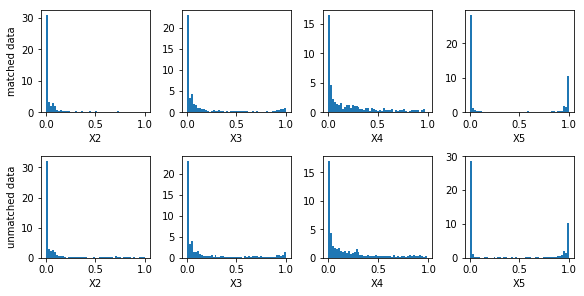

In [36]:
f, (axs1, axs2) = plt.subplots(2, 4, figsize=(8,4), constrained_layout=True)

for i in range(p-1):
    axs1[i].hist(data.loc[data.match == 1, 'X' + str(i + 2)], 50, density=True)
    axs1[i].set_xlabel('X' + str(i + 2))
    axs2[i].hist(data.loc[data.match == -1, 'X' + str(i + 2)], 50, density=True)
    axs2[i].set_xlabel('X' + str(i + 2))

axs1[0].set_ylabel("matched data")
axs2[0].set_ylabel("unmatched data")

plt.savefig("yahoo_data.pdf")

In [35]:
from scipy.stats import t

print('Data used: {}, data matched: {}'.format(sum(data.match != 0), YahooLogistic.step))
print('Parameter estimation:')
print(' ' * 7 + 'estimate    s.e. [  95% Wald CI] t value P(>|t|)')
for i in [0,1]:
    for j in range(p):
        est = YahooLogistic.beta_bar[i * p + j]
        se = YahooLogistic.se_hat[i * p + j]
        lo = est - 1.96 * se
        up = est + 1.96 * se
        tv = est/se
        pv = 2 * t.sf(abs(tv), YahooLogistic.step - 2 * p)
        print('beta' + str(i) + str(j + 1) + 
              '{:9.4f}{:8.4f}{:8.4f}{:8.4f}{:8.2f}{:8.4f}'.format(est, se, lo, up, tv, pv))
print('Value estimation:')
print('value {:9.4f}{:8.4f}'.format(YahooLogistic.val_hat, YahooLogistic.vse_hat) + 
     '{:8.4f}{:8.4f}'.format(YahooLogistic.val_hat - 1.96 * YahooLogistic.vse_hat, 
                             YahooLogistic.val_hat + 1.96 * YahooLogistic.vse_hat) +
     '{:8.2f}{:8.4f}'.format(YahooLogistic.val_hat/YahooLogistic.vse_hat, 
                             2 * t.sf(abs(YahooLogistic.val_hat/YahooLogistic.vse_hat), YahooLogistic.step - 2 * p)))
# Output:
# Data used: 405888, data matched: 203909
# Parameter estimation:
#        estimate    s.e. [  95% Wald CI]
# beta01  -2.8226  0.0810 -2.9814 -2.6637
# beta02  -0.4220  0.1498 -0.7155 -0.1285
# beta03  -0.4022  0.1275 -0.6521 -0.1522
# beta04   0.1689  0.1282 -0.0824  0.4202
# beta05  -1.0909  0.1111 -1.3087 -0.8731
# beta11  -2.6272  0.0354 -2.6965 -2.5578
# beta12  -0.2787  0.0572 -0.3909 -0.1665
# beta13  -0.3692  0.0498 -0.4668 -0.2717
# beta14  -0.0562  0.0883 -0.2294  0.1170
# beta15  -1.0890  0.0567 -1.2002 -0.9778
# Value estimation:
# value    0.0515  0.0005  0.0505  0.0525

Data used: 1933, data matched: 1000
Parameter estimation:
       estimate    s.e. [  95% Wald CI] t value P(>|t|)
beta01  -1.7477  0.2345 -2.2073 -1.2880   -7.45  0.0000
beta02  -0.1537  0.4295 -0.9955  0.6880   -0.36  0.7204
beta03  -0.3163  0.3412 -0.9850  0.3523   -0.93  0.3540
beta04  -0.3050  0.4193 -1.1269  0.5170   -0.73  0.4673
beta05  -0.4878  0.2544 -0.9864  0.0108   -1.92  0.0555
beta11  -1.8233  0.6647 -3.1261 -0.5206   -2.74  0.0062
beta12  -0.1360  1.2642 -2.6139  2.3418   -0.11  0.9143
beta13  -0.3756  0.8340 -2.0103  1.2592   -0.45  0.6526
beta14  -0.2989  0.9989 -2.2568  1.6590   -0.30  0.7648
beta15  -0.7293  0.6945 -2.0905  0.6319   -1.05  0.2939
Value estimation:
value    0.0344  0.0061  0.0225  0.0464    5.66  0.0000


# Misc

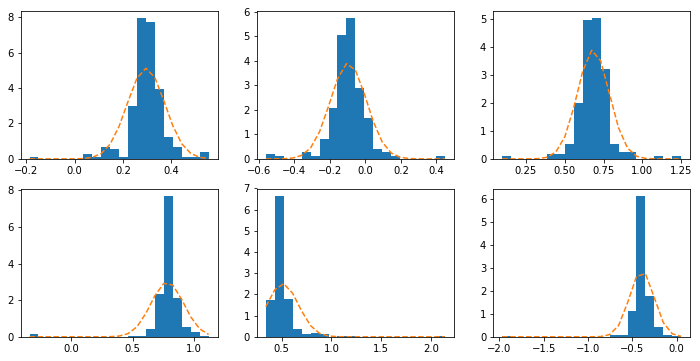

In [21]:
means = np.mean(beta_bar, axis = 0)
sds = np.std(beta_bar, axis = 0)
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (12, 6))
for i, ax in enumerate(axes.flat):
    n, bins, patches = ax.hist(beta_bar[:,i], 20, density = True)
    ysd = ((1 / (np.sqrt(2 * np.pi) * sds[i])) *
     np.exp(-0.5 * (1 / sds[i] * (bins - means[i]))**2))
    ax.plot(bins, ysd, '--')

In [27]:
print('MCSD           : ', np.round(mcsd, 4))
print('Avg Plugin SE  : ', np.round(plugin_se, 4))
print('Avg Resample SE: ', np.round(resample_se, 4))

MCSD           :  [0.078  0.1023 0.1025 0.1337 0.1589 0.1389]
Avg Plugin SE  :  [0.0304 0.0343 0.0323 0.0282 0.0357 0.0375]
Avg Resample SE:  [0.2077 0.2625 0.2546 0.2526 0.26   0.3089]


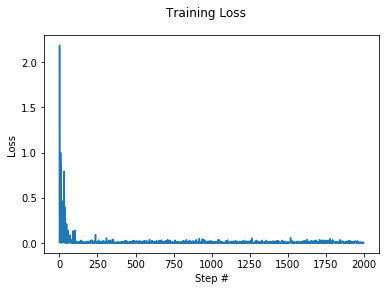

In [17]:
fig = plt.figure()
plt.plot(np.arange(0, T), loss_log)
fig.suptitle("Training Loss")
plt.xlabel("Step #")
plt.ylabel("Loss")
plt.show()

In [12]:
beta_hat_MC = []
for m in range(1000):
    loss_log, beta_hat_log, data_log = LinearModel.SGD(T)
    beta_hat_MC.append(beta_hat - beta_true)

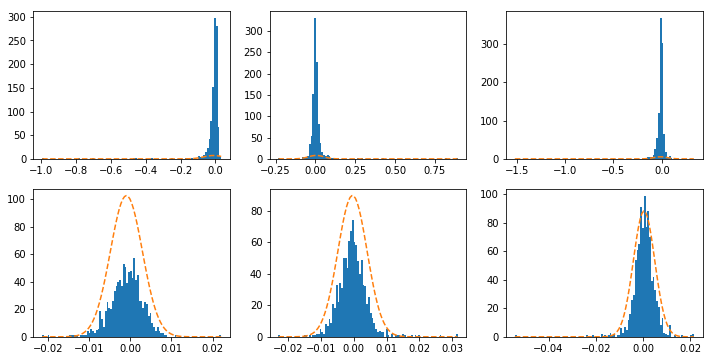

In [13]:
beta_hat_MC = np.asarray(beta_hatMC)
means = np.mean(beta_hatMC, axis=0)
sds = np.std(beta_hatMC, axis=0)
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    n, bins, patches = ax.hist(beta_hat_MC[:,i], 100)
    y = ((1 / (np.sqrt(2 * np.pi) * sds[i])) *
     np.exp(-0.5 * (1 / sds[i] * (bins - means[i]))**2))
    ax.plot(bins, y, '--')

In [14]:
random.seed('odm')
beta_hat_MC_sipwgd = []
for m in range(1000):
    _, beta_hat = LinearModel.SGD(T)
    beta_hat_MC_sipwgd.append(beta_hat - beta_true)

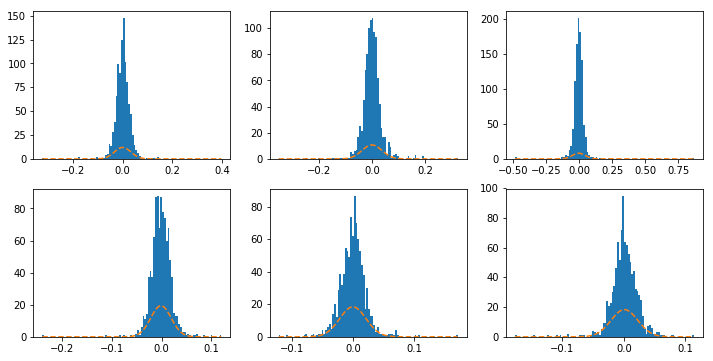

In [15]:
beta_hat_MC_sipwgd = np.asarray(beta_hat_MC_sipwgd)
means = np.mean(beta_hat_MC_sipwgd, axis=0)
sds = np.std(beta_hat_MC_sipwgd, axis=0)
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    n, bins, patches = ax.hist(beta_hat_MC_sipwgd[:,i], 100)
    y = ((1 / (np.sqrt(2 * np.pi) * sds[i])) *
     np.exp(-0.5 * (1 / sds[i] * (bins - means[i]))**2))
    ax.plot(bins, y, '--')

In [19]:
beta_hat_MC = []
for m in range(1000):
    _, beta_hat = LogisticModel.SGD(T)
    beta_hatMC.append(beta_hat - beta_true)

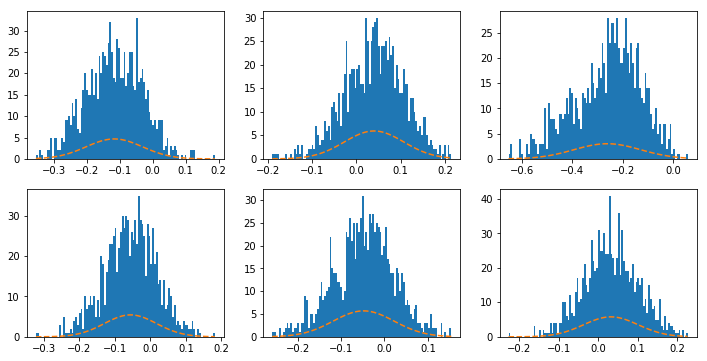

In [20]:
beta_hat_MC = np.asarray(beta_hat_MC)
means = np.mean(beta_hat_MC, axis=0)
sds = np.std(beta_hat_MC, axis=0)
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    n, bins, patches = ax.hist(beta_hat_MC[:,i], 100)
    y = ((1 / (np.sqrt(2 * np.pi) * sds[i])) *
     np.exp(-0.5 * (1 / sds[i] * (bins - means[i]))**2))
    ax.plot(bins, y, '--')

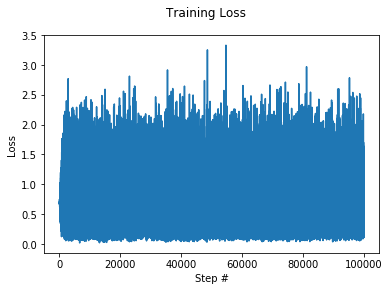

In [20]:
random.seed('chy')
T=100000

loss_log, beta_hat_log = LogisticModel.SGD(T)

fig = plt.figure()
plt.plot(np.arange(0, T), lossLog)
fig.suptitle("Training Loss")
plt.xlabel("Step #")
plt.ylabel("Loss")
plt.show()

In [16]:
beta_hat_log

array([ 0.34903699, -0.13422294,  0.74818192,  0.82848765,  0.50994558,
       -0.33408271])

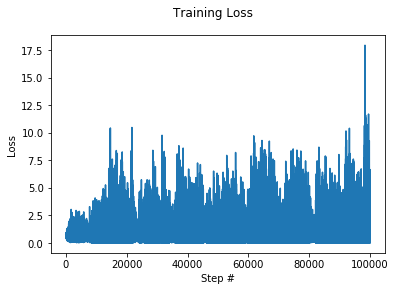

In [19]:
random.seed('chy')
T=100000

loss_log_sipwgd, beta_hat_log_sipwgd = LogisticModel.SIPWGD(T)

fig = plt.figure()
plt.plot(np.arange(0, T), loss_log_sipwgd)
fig.suptitle("Training Loss")
plt.xlabel("Step #")
plt.ylabel("Loss")
plt.show()